In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-09 04:41:25.786092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 04:41:26.378775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [75]:
pickle_file_path = './data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

pickle_file_path = './data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)
    



In [3]:



mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
# FEATURE_COLS = test_df.columns[1:-4].tolist()

selected_features_pickle_path = './data/selected_features_list.pickle'
with open(selected_features_pickle_path, 'rb') as f:
    FEATURE_COLS = pickle.load(f)

print(FEATURE_COLS)



['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg', 'SOIL_phh2o_100.200cm_mean_0.01_deg', 'SOIL_phh2o_15.30cm_mean_0.01_deg', 'SOIL_phh2o_30.60cm_mean_0.01_deg', 'SOIL_phh2o_5.15cm_mean_0.01_deg', 'SOIL_phh2o_60.100cm_mean_0.01_deg', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12'

In [4]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000
mean,0.521268,15.910891,3.160711,1.615603,41.319274,1843.646287
std,0.145251,7.863849,5.322841,0.662838,164.948299,3153.292771
min,0.006996,1.186970,0.002919,0.076517,0.000179,1.108830
25%,0.411105,10.759204,0.306121,1.176479,0.545185,256.789938
50%,0.507643,15.164677,0.697812,1.476696,2.420592,711.579570
75%,0.620997,19.620579,3.313238,1.911236,13.790889,2064.455660
max,0.958177,60.206352,33.275509,5.002875,2387.617647,31535.016150


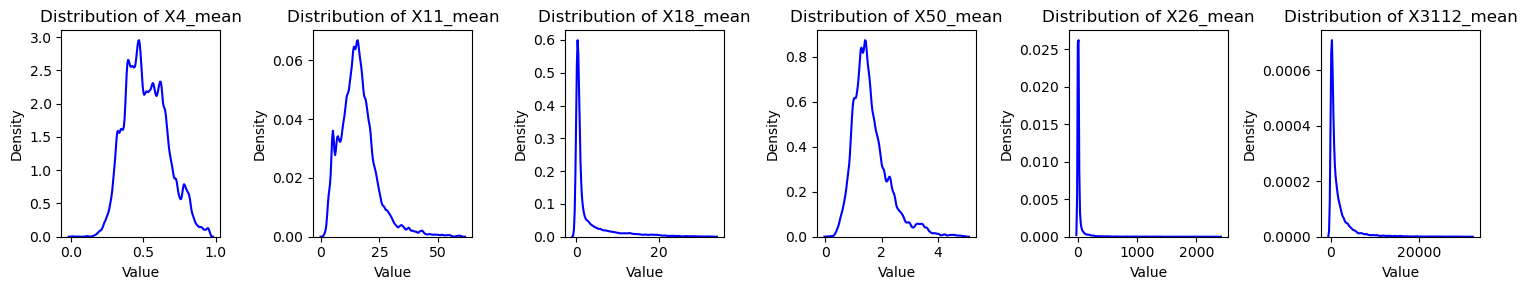

In [7]:
plot_data(train_df, mean_columns)

In [8]:
# train_df[mean_columns] = np.log10(train_df[mean_columns])

In [9]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000
mean,0.521268,15.910891,3.160711,1.615603,41.319274,1843.646287
std,0.145251,7.863849,5.322841,0.662838,164.948299,3153.292771
min,0.006996,1.186970,0.002919,0.076517,0.000179,1.108830
25%,0.411105,10.759204,0.306121,1.176479,0.545185,256.789938
50%,0.507643,15.164677,0.697812,1.476696,2.420592,711.579570
75%,0.620997,19.620579,3.313238,1.911236,13.790889,2064.455660
max,0.958177,60.206352,33.275509,5.002875,2387.617647,31535.016150


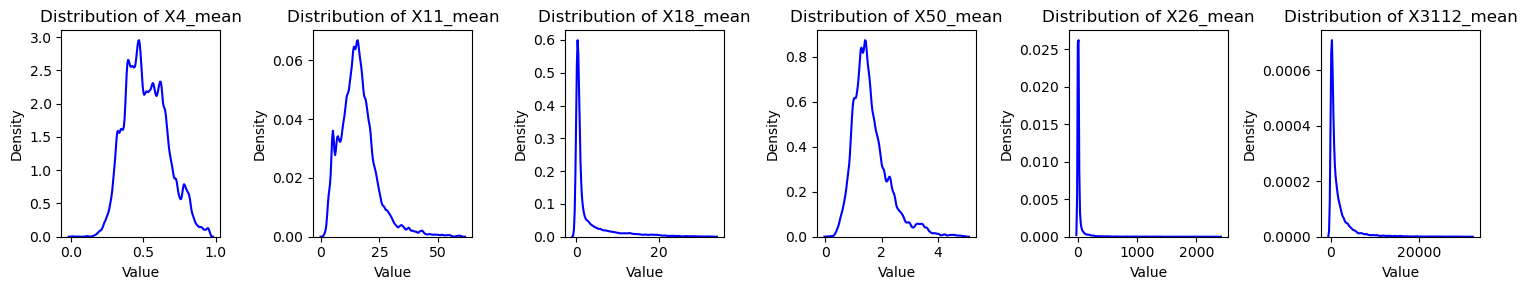

In [10]:
plot_data(train_df, mean_columns)

In [72]:
print(train_df['fold'].value_counts())

# scaler = StandardScaler() # TODO testaa robustscaler
scaler = RobustScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

with open('./data/scaler_tabufeatures_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)




fold
2.0    10736
0.0    10736
3.0    10736
1.0    10736
4.0    10735
Name: count, dtype: int64
# Num Train: 42943 | Num Valid: 10736


/tmp/ipykernel_369150/2055694891.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_369150/2055694891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [12]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
# y_train = train_df[mean_columns].values
y_train = train_df[mean_columns]

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
# y_valid = valid_df[mean_columns].values
y_valid = valid_df[mean_columns]



In [13]:
print(X_train_tab.shape)

(42943, 81)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0))


def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss


global current_delta
def create_model(trial):

    image_features_input = Input(shape=(X_train_feat.shape[1],), name='image_features_input')
    tabular_data_input = Input(shape=(X_train_tab.shape[1],), name='tabular_data_input')

    img_num_layers = trial.suggest_int('Imgage layers', 1, 2)
    max_img_units = 2000
    img_dense = image_features_input

    image_init = trial.suggest_categorical(f'Img_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_img = trial.suggest_categorical(f'Act_img', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_img = trial.suggest_float(f'Drop_img', 0.2, 0.7, step=0.1)
    batch_norm_img = trial.suggest_categorical(f'Img_BatchN', choices = ['On', 'Off'])
    for i in range(img_num_layers):

        num_img_units = trial.suggest_int(f'Num_img_{i}', 128, max_img_units, log = True)
        img_dense = Dense(num_img_units, activation=activation_img, kernel_initializer = image_init)(img_dense)
        if batch_norm_img == 'On':
            img_dense = layers.BatchNormalization()(img_dense)
        img_dense = Dropout(drop_img)(img_dense)
        max_img_units = min(max_img_units, num_img_units)


    tab_num_layers = trial.suggest_int('Tabular layers', 1, 2)
    max_tab_units = 1000
    tab_dense = tabular_data_input
    tab_init = trial.suggest_categorical(f'Tab_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_tab = trial.suggest_categorical(f'Act_tab', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_tab = trial.suggest_float(f'Drop_tab', 0.2, 0.7, step = 0.1)
    batch_norm_tab = trial.suggest_categorical(f'Tab_BatchN', choices = ['On', 'Off'])
    for i in range(tab_num_layers):

        num_tab_units = trial.suggest_int(f'Num_tab_{i}', 64, max_tab_units, log = True)
        tab_dense = Dense(num_tab_units, activation=activation_tab, kernel_initializer = tab_init)(tab_dense)
        if batch_norm_tab == 'On':
            tab_dense = layers.BatchNormalization()(tab_dense)
        tab_dense = Dropout(drop_tab)(tab_dense)

        max_tab_units = min(max_tab_units, num_tab_units)


    concatenated = Concatenate()([img_dense, tab_dense])
    com_num_layers = trial.suggest_int('Concat layers', 1, 2)
    max_com_units = 3000
    con_init = trial.suggest_categorical(f'Con_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'random_normal', 'random_uniform'])
    activation_common = trial.suggest_categorical(f'Act_con',  choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_common = trial.suggest_float(f'Drop_con', 0.2, 0.7, step = 0.1)
    batch_norm_common = trial.suggest_categorical(f'Com_BatchN', ['On', 'Off'])
    for i in range(com_num_layers):

        num_common_units = trial.suggest_int(f'Num_con_{i}', 128, max_com_units, log = True)
        concatenated = Dense(num_common_units, activation=activation_common, kernel_initializer = con_init)(concatenated)
        if batch_norm_common == 'On':
            concatenated = layers.BatchNormalization()(concatenated)
        concatenated = Dropout(drop_common)(concatenated)

        max_com_units = min(max_com_units, num_common_units)

    output = Dense(6, activation='linear')(concatenated)
    model = Model(inputs=[image_features_input, tabular_data_input], outputs=output)


    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)

    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop()
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam()
    else:
        optimizer = optimizers.Adamax()

    # delta = trial.suggest_float('delta', 0.0, 2.5)
    # global current_delta
    # current_delta = delta

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse','mae', r2_score])
    # model.compile(optimizer=optimizers.Adam(), loss=huber_loss_wrapper(delta), metrics=['mse','mae', r2_score])
    # model.compile(optimizer= optimizers.Adam(), loss='mse', metrics=['mse','mae', r2_score])
    return model



def objective(trial):

    model = create_model(trial)

    y_train_transformed = y_train.copy()
    y_valid_transformed = y_valid.copy()


    log_base_options = {'none': None, 'log2': 2, 'log10': 10, 'sqrt' : 'sqrt', 'cbrt' : 'cbrt'}
    log_transforms = {}
    for target in mean_columns:
        log_base = trial.suggest_categorical(f'Log_{target}', list(log_base_options.keys()))
        log_transforms[target] = log_base_options[log_base]

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./data/{study_name}_search_model.h5",
            monitor='val_r2_score',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=0)


    callbacks = [
                 ReduceLROnPlateau('val_r2_score', patience=2, factor=0.7, mode = 'max'),
                 TerminateOnNaN(),
                 model_checkpoint_callback,
                 EarlyStopping(monitor='val_r2_score', patience=3, mode='max', verbose = 1)
                 ]

    for target, log_base in log_transforms.items():
        if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
            y_train_transformed[target] = np.log(y_train[target]) / np.log(log_base)
            y_valid_transformed[target] = np.log(y_valid[target]) / np.log(log_base)

        elif log_base == 'sqrt':
            y_train_transformed[target] = np.sqrt(y_train[target])
            y_valid_transformed[target] = np.sqrt(y_valid[target])

        elif log_base == 'cbrt':
            y_train_transformed[target] = np.cbrt(y_train[target])
            y_valid_transformed[target] = np.cbrt(y_valid[target])

        else:
            y_train_transformed[target] = y_train[target]
            y_valid_transformed[target] = y_valid[target]

    # scaler_base_options = {'Std': StandardScaler(), 'Minmax': MinMaxScaler(), 'Robust': RobustScaler(), 'None': None}
    # scaler_transforms = {}
    # for target in mean_columns:
    #     scaler_base = trial.suggest_categorical(f'Scaler_{target}', list(scaler_base_options.keys()))
    #     scaler_transforms[target] = scaler_base_options[scaler_base]

    minmax_scaler = MinMaxScaler()
    y_train_transformed = minmax_scaler.fit_transform(y_train_transformed)
    y_valid_transformed = minmax_scaler.transform(y_valid_transformed)

    history = model.fit([X_train_feat, X_train_tab], y_train_transformed, validation_data=([X_valid_feat, X_valid_tab], y_valid_transformed), batch_size=256, epochs=5, callbacks=callbacks, verbose = 0)

    best_epoch = history.history['val_r2_score'].index(max(history.history['val_r2_score'])) + 1

    model.load_weights(f'./data/{study_name}_search_model.h5')

    preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)

    preds_transformed = preds.copy()

    # for i, target in enumerate(mean_columns):
    #     scaler = scaler_transforms[target]
    #     if scaler is not None:
    #         preds_transformed[:, i] = scaler.inverse_transform(preds_transformed[:, i].reshape(-1, 1)).flatten()
    #         y_valid_transformed[target] = scaler.inverse_transform(y_valid_transformed[target].values.reshape(-1, 1)).flatten()

    preds_transformed = minmax_scaler.inverse_transform(preds_transformed)

    for i, target in enumerate(mean_columns):
        log_base = log_transforms[target]
        if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
            preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
            y_valid_transformed[target] = np.power(log_base, y_valid_transformed[target])
        elif log_base == 'sqrt':   
            preds_transformed[:, i] = np.square(preds_transformed[:, i])
            y_valid_transformed[target] = np.square(y_valid_transformed[target])
        elif log_base == 'cbrt':
            preds_transformed[:, i] = np.power(preds_transformed[:, i], 3)
            y_valid_transformed[target] = np.power(y_valid_transformed[target], 3)
        
    r2_score_inv = r2_score(y_valid_transformed, preds_transformed)

    if trial.number > 0:
        if r2_score_inv > study.best_value:

            print("*" * 50)
            print(f'Old best R2 : {study.best_value:.5f}')
            print(f'New best R2 : {r2_score_inv:.5f}')

            r2 = r2_score(y_valid_transformed, preds_transformed)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid_transformed, preds_transformed)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid_transformed, preds_transformed)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_transformed, preds_transformed)
            print(f'Best epoch power errors R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')


            # model.load_weights(f'./data/{study_name}_search_model.h5')

            # preds = model.predict([X_valid_feat, X_valid_tab])
            # preds_2 = np.square(preds)
            # # y_valid_2 = np.square(y_valid)
            # preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)

            # r2 = r2_score(y_valid_transformed, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw errors : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds_inv = scaler_minmax.inverse_transform(preds)
            # y_valid_inv = scaler_minmax.inverse_transform(y_valid)
            # r2 = r2_score(y_valid_inv, preds_inv)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid_inv, preds_inv)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid_inv, preds_inv)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # print(f'Best epoch minmax.inv R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds = model.predict([X_valid_feat, X_valid_tab])
            # r2 = r2_score(y_valid, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid, preds)
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            print(f'Best epoch : {best_epoch}')

            best_filename = f'./data/{study_name}_best_val_{r2_score_inv:.5f}_model.h5'
            if os.path.exists(best_filename):
                os.remove(best_filename)

            print(f'Saving model to {best_filename}')
            model.save(best_filename)

            print(f'Saving log transforms to {study_name}_{r2_score_inv:.5f}_best_log_transforms.pickle')
            with open(f'./data/{study_name}_{r2_score_inv:.5f}_best_log_transforms.pickle', 'wb') as f:
                pickle.dump(log_transforms, f)

            print(f'Saving minmax scaler to {study_name}_{r2_score_inv:.5f}_best_minmax_scaler.pickle')
            with open(f'./data/{study_name}_{r2_score_inv:.5f}_best_minmax_scaler.pickle', 'wb') as f:
                pickle.dump(minmax_scaler, f)

            print("*" * 50)

    if os.path.exists(f'./data/{study_name}_search_model.h5'):
        os.remove(f'./data/{study_name}_search_model.h5')

    tf.keras.backend.clear_session()
    gc.collect()

    return r2_score_inv


study_name = '409_logselect_testi_fold_3'
num_random_trials = 10
num_tpe_trial = 3
search_time_max = 3600 * 18

study = optuna.create_study(direction='maximize',
                            study_name=study_name,
                            storage=f'sqlite:///409_logpolselect.db',
                            load_if_exists=True
                            )

search_time_taken = 0
search_start = time.time()
round = 0

while search_time_taken < search_time_max:

    round_start = time.time()

    print('-' * 50)
    print(f'Starting study with {num_random_trials} random trials, round {round}')
    print(f'Search time so far taken : {timedelta(seconds=search_time_taken)}')
    print('-' * 50)
    study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_random_trials)
    print(f'Time taken for random trials: {timedelta(seconds= (time.time() - round_start))}')
    print(f'Starting TPE {num_tpe_trial} trials...')
    study.sampler = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_tpe_trial)
    print(f'Time taken for one trial: {timedelta(seconds= (time.time() - round_start) / (num_random_trials + num_tpe_trial))}')
    print(f'Time this round: {timedelta(seconds= time.time() - round_start)}')

    search_time_taken = time.time() - search_start
    round += 1

print(f'Search time total : {timedelta(seconds=time.time() - search_start)}')






[I 2024-04-09 04:41:32,816] A new study created in RDB with name: 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)


Starting study with 10 random trials, round 0
Search time so far taken : 0:00:00
--------------------------------------------------


2024-04-09 04:41:33.124388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 04:41:33.159651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 04:41:33.159727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 04:41:33.163916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 04:41:33.163999: I tensorflow/compile

Epoch 10: early stopping


[I 2024-04-09 04:42:02,123] Trial 0 finished with value: 0.12407545842309063 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 329, 'Num_img_1': 215, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 298, 'Num_tab_1': 139, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 296, 'Num_con_1': 130, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 0 with value: 0.12407545842309063.


Epoch 19: early stopping
**************************************************
Old best R2 : 0.12408
New best R2 : 0.19154
Best epoch power errors R2 : 0.19154, MSE : 2733524.50000, MAE : 436.76038
Best epoch : 16
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.19154_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.19154_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.19154_scalers.pickle
**************************************************


[I 2024-04-09 04:43:10,626] Trial 1 finished with value: 0.1915375286625529 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 128, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 64, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 128, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 1 with value: 0.1915375286625529.


Epoch 14: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])


**************************************************
Old best R2 : 0.19154
New best R2 : 0.19641
Best epoch power errors R2 : 0.19641, MSE : nan, MAE : nan
Best epoch : 11
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.19641_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.19641_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.19641_scalers.pickle
**************************************************


[I 2024-04-09 04:43:42,625] Trial 2 finished with value: 0.19640888068437645 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 505, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 252, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 619, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 2 with value: 0.19640888068437645.


Epoch 35: early stopping
**************************************************
Old best R2 : 0.19641
New best R2 : 0.27734
Best epoch power errors R2 : 0.27734, MSE : 1387088.87500, MAE : 217.97635
Best epoch : 32
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.27734_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.27734_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.27734_scalers.pickle
**************************************************


[I 2024-04-09 04:46:07,406] Trial 3 finished with value: 0.2773381358984465 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 254, 'Num_img_1': 162, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 127, 'Num_tab_1': 103, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1362, 'Num_con_1': 240, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.2773381358984465.


Epoch 13: early stopping


[I 2024-04-09 04:46:33,454] Trial 4 finished with value: 0.011492434430134072 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1005, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 502, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 281, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 3 with value: 0.2773381358984465.


Epoch 16: early stopping


[I 2024-04-09 04:47:11,740] Trial 5 finished with value: 0.0807817891877115 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 712, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 179, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 2022, 'Num_con_1': 175, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 3 with value: 0.2773381358984465.


Epoch 22: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 04:48:03,149] Trial 6 finished with value: 0.09063402899750996 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 180, 'Num_img_1': 135, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 709, 'Num_tab_1': 113, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 417, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Min

Epoch 10: early stopping


[I 2024-04-09 04:48:44,849] Trial 7 finished with value: 0.1052255358591216 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1418, 'Num_img_1': 231, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 90, 'Num_tab_1': 77, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 189, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 3 with value: 0.2773381358984465.


Epoch 4: early stopping


[I 2024-04-09 04:48:59,319] Trial 8 finished with value: 0.038046700824061495 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 358, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 356, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 918, 'Num_con_1': 142, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 3 with value: 0.2773381358984465.


Epoch 18: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 04:49:51,305] Trial 9 finished with value: 0.11066667434440662 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1684, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 212, 'Num_tab_1': 145, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1118, 'Num_con_1': 134, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'S

Time taken for random trials: 0:08:18.485462
Starting TPE 3 trials...
Epoch 19: early stopping
**************************************************
Old best R2 : 0.27734
New best R2 : 0.32381
Best epoch power errors R2 : 0.32381, MSE : 1354956.25000, MAE : 210.30220
Best epoch : 16
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.32381_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.32381_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.32381_scalers.pickle
**************************************************


[I 2024-04-09 04:51:29,326] Trial 10 finished with value: 0.3238141591748076 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 636, 'Num_img_1': 582, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 354, 'Num_tab_1': 317, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 838, 'Num_con_1': 405, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 48: early stopping


[I 2024-04-09 04:54:15,227] Trial 11 finished with value: 0.29705723659051486 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 551, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 141, 'Num_tab_1': 141, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1473, 'Num_con_1': 549, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 12: early stopping


[I 2024-04-09 04:55:08,984] Trial 12 finished with value: 0.18098945746627118 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1020, 'Num_img_1': 734, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 513, 'Num_tab_1': 353, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1163, 'Num_con_1': 589, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QM

Time taken for one trial: 0:01:02.781921
Time this round: 0:13:36.165033
Starting study with 10 random trials, round 1
Search time so far taken : 0:13:36.165184
--------------------------------------------------
Epoch 23: early stopping


[I 2024-04-09 04:56:42,111] Trial 13 finished with value: 0.1358620776472673 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 425, 'Num_img_1': 311, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 842, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 231, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 20: early stopping


[I 2024-04-09 04:57:24,048] Trial 14 finished with value: 0.08546959573889551 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 846, 'Num_img_1': 152, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 106, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 508, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 9: early stopping


[I 2024-04-09 04:57:46,567] Trial 15 finished with value: 0.17152212865130415 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 214, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 423, 'Num_tab_1': 184, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 2463, 'Num_con_1': 166, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 26: early stopping


[I 2024-04-09 04:58:32,781] Trial 16 finished with value: 0.1952205604639249 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 301, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 75, 'Num_tab_1': 70, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 342, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 5: early stopping


[I 2024-04-09 04:58:46,481] Trial 17 finished with value: 0.010604813009916022 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1194, 'Num_img_1': 135, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 299, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1660, 'Num_con_1': 281, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 19: early stopping


[I 2024-04-09 04:59:30,752] Trial 18 finished with value: 0.18013486719125563 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 151, 'Num_img_1': 133, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 150, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 753, 'Num_con_1': 228, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.
[I 2024-04-09 05:01:18,006] Trial 19 finished with value: 0.17475015283793227 and 

Epoch 9: early stopping


[I 2024-04-09 05:01:41,977] Trial 20 finished with value: 0.04158878847460088 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 463, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 275, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 171, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 15: early stopping


[I 2024-04-09 05:02:13,104] Trial 21 finished with value: 0.06925201039845731 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1836, 'Num_img_1': 148, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 69, 'Num_tab_1': 64, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 832, 'Num_con_1': 274, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 17: early stopping


[I 2024-04-09 05:03:07,383] Trial 22 finished with value: 0.028463189923086978 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 233, 'Num_img_1': 177, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 547, 'Num_tab_1': 73, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1832, 'Num_con_1': 222, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 10 with value: 0.3238141591748076.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optu

Time taken for random trials: 0:07:58.398659
Starting TPE 3 trials...
Epoch 27: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:04:43,476] Trial 23 finished with value: 0.1457881283849581 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 193, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 97, 'Num_tab_1': 89, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1797, 'Num_con_1': 1157, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Be

Epoch 9: early stopping


[I 2024-04-09 05:05:29,316] Trial 24 finished with value: 0.25530829817027223 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 223, 'Num_img_1': 174, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 184, 'Num_tab_1': 170, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 301, 'Num_con_1': 286, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 10: early stopping


[I 2024-04-09 05:06:06,773] Trial 25 finished with value: 0.25162104558698456 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 769, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 138, 'Num_tab_1': 115, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1565, 'Num_con_1': 541, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMC

Time taken for one trial: 0:00:50.599116
Time this round: 0:10:57.788565
Starting study with 10 random trials, round 2
Search time so far taken : 0:24:33.953760
--------------------------------------------------
Epoch 29: early stopping


[I 2024-04-09 05:07:21,873] Trial 26 finished with value: 0.21323829194386257 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 922, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 138, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 378, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 13: early stopping


[I 2024-04-09 05:07:57,834] Trial 27 finished with value: 0.055530613738532277 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 1301, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 773, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2718, 'Num_con_1': 131, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 13: early stopping


[I 2024-04-09 05:08:36,477] Trial 28 finished with value: 0.14625848894229732 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 328, 'Num_img_1': 268, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 195, 'Num_tab_1': 193, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 560, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 46: early stopping


[I 2024-04-09 05:10:32,276] Trial 29 finished with value: 0.158625810548959 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 654, 'Num_img_1': 131, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 388, 'Num_tab_1': 284, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 254, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.
[I 2024-04-09 05:13:13,550] Trial 30 finished with value: 0.10221190617047564 and paramete

Epoch 26: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:14:31,179] Trial 31 finished with value: 0.0972566989628287 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 550, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 918, 'Num_tab_1': 81, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1013, 'Num_con_1': 189, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial

Epoch 18: early stopping


[I 2024-04-09 05:15:25,092] Trial 32 finished with value: 0.06602143783129359 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 139, 'Num_img_1': 129, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 231, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 209, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 23: early stopping


[I 2024-04-09 05:16:35,856] Trial 33 finished with value: 0.18933077455089375 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1095, 'Num_img_1': 224, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 461, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 460, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 15: early stopping


[I 2024-04-09 05:17:11,712] Trial 34 finished with value: 0.05578537966833478 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 277, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 116, 'Num_tab_1': 90, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 2232, 'Num_con_1': 153, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 15: early stopping


[I 2024-04-09 05:18:08,653] Trial 35 finished with value: 0.01760250609751581 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 196, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 326, 'Num_tab_1': 213, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 310, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 10 with value: 0.3238141591748076.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWa

Time taken for random trials: 0:12:01.879954
Starting TPE 3 trials...
Epoch 12: early stopping


[I 2024-04-09 05:18:55,344] Trial 36 finished with value: 0.20631835891004777 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 276, 'Num_img_1': 181, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 226, 'Num_tab_1': 152, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 328, 'Num_con_1': 308, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 9: early stopping


[I 2024-04-09 05:19:38,321] Trial 37 finished with value: 0.10920644689696378 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 179, 'Num_img_1': 163, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 71, 'Num_tab_1': 68, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 1948, 'Num_con_1': 462, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 7: early stopping


[I 2024-04-09 05:20:15,432] Trial 38 finished with value: 0.30983833897539154 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 860, 'Num_img_1': 622, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 271, 'Num_tab_1': 230, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 765, 'Num_con_1': 383, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is ex

Time taken for one trial: 0:01:05.281534
Time this round: 0:14:08.660006
Starting study with 10 random trials, round 3
Search time so far taken : 0:38:42.613776
--------------------------------------------------
Epoch 10: early stopping


[I 2024-04-09 05:20:39,704] Trial 39 finished with value: 0.014539779515894488 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 776, 'Num_img_1': 252, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 82, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1504, 'Num_con_1': 210, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 23: early stopping


[I 2024-04-09 05:21:57,973] Trial 40 finished with value: 0.12786300634861483 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 390, 'Num_img_1': 199, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 650, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 683, 'Num_con_1': 260, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 13: early stopping


[I 2024-04-09 05:22:39,350] Trial 41 finished with value: 0.15766057755399218 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1545, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 164, 'Num_tab_1': 144, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 141, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 25: early stopping


[I 2024-04-09 05:24:01,898] Trial 42 finished with value: 0.14434703516219302 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 883, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 571, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 438, 'Num_con_1': 285, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 32: early stopping


[I 2024-04-09 05:25:55,787] Trial 43 finished with value: 0.2700479877968309 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 223, 'Num_img_1': 133, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 144, 'Num_tab_1': 83, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2124, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 9: early stopping


[I 2024-04-09 05:26:23,610] Trial 44 finished with value: 0.013980373935401136 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 1758, 'Num_img_1': 272, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 287, 'Num_tab_1': 122, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 964, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 14: early stopping


[I 2024-04-09 05:26:54,849] Trial 45 finished with value: 0.10088281642647406 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 444, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 72, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 199, 'Num_con_1': 174, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 18: early stopping


[I 2024-04-09 05:27:49,168] Trial 46 finished with value: 0.1235608839205135 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 158, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 405, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 650, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 31: early stopping


[I 2024-04-09 05:29:47,752] Trial 47 finished with value: 0.2330290935000224 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 626, 'Num_img_1': 306, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 102, 'Num_tab_1': 81, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 134, 'Num_con_1': 130, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 16: early stopping


[I 2024-04-09 05:31:03,170] Trial 48 finished with value: 0.1270959058658169 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 315, 'Num_img_1': 150, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 807, 'Num_tab_1': 148, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 295, 'Num_con_1': 168, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler

Time taken for random trials: 0:10:47.737150
Starting TPE 3 trials...
Epoch 28: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:32:39,851] Trial 49 finished with value: 0.12750548857521815 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 654, 'Num_img_1': 461, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 156, 'Num_tab_1': 102, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1953, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mea

Epoch 26: early stopping


[I 2024-04-09 05:34:29,447] Trial 50 finished with value: 0.3201221994065036 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 644, 'Num_img_1': 510, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 417, 'Num_tab_1': 291, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 645, 'Num_con_1': 409, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 31: early stopping


[I 2024-04-09 05:36:26,472] Trial 51 finished with value: 0.3138558113093965 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 610, 'Num_img_1': 513, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 335, 'Num_tab_1': 273, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 729, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from 

Time taken for one trial: 0:01:14.695329
Time this round: 0:16:11.039326
Starting study with 10 random trials, round 4
Search time so far taken : 0:54:53.653114
--------------------------------------------------


[I 2024-04-09 05:38:10,428] Trial 52 finished with value: 0.25873041498416977 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1246, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 203, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1431, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 37: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:39:32,433] Trial 53 finished with value: 0.21716360826841954 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 265, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 481, 'Num_tab_1': 111, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1744, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best

Epoch 19: early stopping


[I 2024-04-09 05:40:44,123] Trial 54 finished with value: 0.1946569758311326 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 1049, 'Num_img_1': 202, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 121, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 359, 'Num_con_1': 177, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 23: early stopping


[I 2024-04-09 05:41:53,668] Trial 55 finished with value: 0.2048154873418171 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 133, 'Num_img_1': 129, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 958, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 163, 'Num_con_1': 144, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 15: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:42:35,159] Trial 56 finished with value: 0.04438729669253729 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 527, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 241, 'Num_tab_1': 75, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 792, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Be

Epoch 12: early stopping


[I 2024-04-09 05:43:03,223] Trial 57 finished with value: 0.14575572477552243 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1480, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 679, 'Num_tab_1': 198, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 242, 'Num_con_1': 197, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 8: early stopping


[I 2024-04-09 05:43:26,249] Trial 58 finished with value: 0.08485407840533958 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 374, 'Num_img_1': 227, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 171, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1175, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 5: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:43:43,391] Trial 59 finished with value: 0.04473422396885764 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 744, 'Num_img_1': 179, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 341, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 2588, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 

Epoch 5: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:43:58,603] Trial 60 finished with value: 0.015169427419681117 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 188, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 86, 'Num_tab_1': 80, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 533, 'Num_con_1': 243, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'S

Epoch 31: early stopping


[I 2024-04-09 05:45:29,184] Trial 61 finished with value: 0.2640570863591658 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1144, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 132, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 589, 'Num_con_1': 213, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Experimenta

Time taken for random trials: 0:09:02.711576
Starting TPE 3 trials...
Epoch 24: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:46:59,318] Trial 62 finished with value: 0.1584590092798732 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 474, 'Num_img_1': 423, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 384, 'Num_tab_1': 291, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 524, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Ro

Epoch 18: early stopping


[I 2024-04-09 05:48:15,763] Trial 63 finished with value: 0.21301399047159775 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 277, 'Num_img_1': 274, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 105, 'Num_tab_1': 97, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 744, 'Num_con_1': 417, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 10 with value: 0.3238141591748076.


Epoch 20: early stopping
**************************************************
Old best R2 : 0.32381
New best R2 : 0.33373
Best epoch power errors R2 : 0.33373, MSE : 1388602.25000, MAE : 208.41263
Best epoch : 17
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.33373_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.33373_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.33373_scalers.pickle
**************************************************


[I 2024-04-09 05:49:31,886] Trial 64 finished with value: 0.33372760347813885 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1629, 'Num_img_1': 681, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 192, 'Num_tab_1': 187, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 359, 'Num_con_1': 333, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental

Time taken for one trial: 0:01:00.416457
Time this round: 0:13:05.413992
Starting study with 10 random trials, round 5
Search time so far taken : 1:07:59.067117
--------------------------------------------------
Epoch 5: early stopping


[I 2024-04-09 05:49:49,187] Trial 65 finished with value: 0.07163364643895902 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 289, 'Num_img_1': 234, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 524, 'Num_tab_1': 278, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2856, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 4: early stopping


[I 2024-04-09 05:50:03,583] Trial 66 finished with value: 0.06008650673136875 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 575, 'Num_img_1': 185, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 66, 'Num_tab_1': 66, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1297, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 40: early stopping


[I 2024-04-09 05:52:03,416] Trial 67 finished with value: 0.2490607662272669 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 145, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 263, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 267, 'Num_con_1': 263, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 15: early stopping


[I 2024-04-09 05:53:02,708] Trial 68 finished with value: 0.18644220710652115 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 407, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 94, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 874, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 16: early stopping


[I 2024-04-09 05:53:46,880] Trial 69 finished with value: 0.19916676906601816 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1613, 'Num_img_1': 164, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 371, 'Num_tab_1': 72, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 180, 'Num_con_1': 176, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 21: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 05:54:52,604] Trial 70 finished with value: 0.20087680213931844 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 205, 'Num_img_1': 161, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 186, 'Num_tab_1': 106, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 397, 'Num_con_1': 155, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean':

Epoch 18: early stopping


[I 2024-04-09 05:56:07,189] Trial 71 finished with value: 0.13653747877007097 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 811, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 740, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1924, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 41: early stopping


[I 2024-04-09 05:58:23,343] Trial 72 finished with value: 0.12657666741228532 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 243, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 111, 'Num_tab_1': 67, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1580, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 47: early stopping


[I 2024-04-09 06:00:28,496] Trial 73 finished with value: 0.20187282054712577 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 963, 'Num_img_1': 280, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 441, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 326, 'Num_con_1': 133, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 18: early stopping


[I 2024-04-09 06:01:57,636] Trial 74 finished with value: 0.16310755117385664 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 484, 'Num_img_1': 137, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 221, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 148, 'Num_con_1': 143, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/

Time taken for random trials: 0:12:25.749998
Starting TPE 3 trials...
Epoch 11: early stopping


[I 2024-04-09 06:02:42,490] Trial 75 finished with value: 0.27836999489309816 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1395, 'Num_img_1': 800, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 379, 'Num_tab_1': 367, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1510, 'Num_con_1': 672, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 14: early stopping


[I 2024-04-09 06:03:39,445] Trial 76 finished with value: 0.27600974787714155 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 808, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 255, 'Num_tab_1': 231, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2431, 'Num_con_1': 717, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 16: early stopping


[I 2024-04-09 06:04:51,886] Trial 77 finished with value: 0.30630189554058235 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 866, 'Num_img_1': 707, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 339, 'Num_tab_1': 324, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 326, 'Num_con_1': 310, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (su

Time taken for one trial: 0:01:10.769239
Time this round: 0:15:20.000178
Starting study with 10 random trials, round 6
Search time so far taken : 1:23:19.067305
--------------------------------------------------
Epoch 20: early stopping


[I 2024-04-09 06:05:54,069] Trial 78 finished with value: 0.211468203856231 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1916, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 879, 'Num_tab_1': 208, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 717, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 22: early stopping


[I 2024-04-09 06:07:18,623] Trial 79 finished with value: 0.21004296452424498 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 682, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 157, 'Num_tab_1': 116, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 219, 'Num_con_1': 191, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 9: early stopping


[I 2024-04-09 06:07:43,314] Trial 80 finished with value: 0.04434065639701643 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 172, 'Num_img_1': 155, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 623, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1064, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 11: early stopping


[I 2024-04-09 06:08:08,015] Trial 81 finished with value: 0.1383118558073458 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1358, 'Num_img_1': 315, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 79, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 2344, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 16: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:08:54,577] Trial 82 finished with value: 0.13879864460813682 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 343, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 313, 'Num_tab_1': 79, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 483, 'Num_con_1': 225, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mea

Epoch 15: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:09:42,301] Trial 83 finished with value: 0.21228380144895806 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1220, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 396, 'Num_tab_1': 88, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2525, 'Num_con_1': 154, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. B

Epoch 44: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:11:16,995] Trial 84 finished with value: 0.15335044464963205 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 308, 'Num_img_1': 175, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 100, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 520, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33

Epoch 4: early stopping


[I 2024-04-09 06:11:33,328] Trial 85 finished with value: 0.06542470024718093 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 613, 'Num_img_1': 222, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 789, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 236, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 15: early stopping


[I 2024-04-09 06:12:23,992] Trial 86 finished with value: 0.13496495834596361 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 155, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 199, 'Num_tab_1': 130, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1146, 'Num_con_1': 191, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 13: early stopping


[I 2024-04-09 06:12:58,017] Trial 87 finished with value: 0.19873076111911966 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 434, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 559, 'Num_tab_1': 232, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 159, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Exp

Time taken for random trials: 0:08:06.130236
Starting TPE 3 trials...
Epoch 33: early stopping


[I 2024-04-09 06:15:11,034] Trial 88 finished with value: 0.21117449469059565 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 531, 'Num_img_1': 529, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 225, 'Num_tab_1': 224, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 894, 'Num_con_1': 415, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 21: early stopping


[I 2024-04-09 06:16:31,807] Trial 89 finished with value: 0.31938813837584806 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1535, 'Num_img_1': 1142, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 247, 'Num_tab_1': 247, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 130, 'Num_con_1': 128, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 18: early stopping


[I 2024-04-09 06:18:00,695] Trial 90 finished with value: 0.28935299990960994 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 632, 'Num_img_1': 627, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 233, 'Num_tab_1': 233, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 756, 'Num_con_1': 391, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: Q

Time taken for one trial: 0:01:00.677549
Time this round: 0:13:08.808188
Starting study with 10 random trials, round 7
Search time so far taken : 1:36:27.875504
--------------------------------------------------
Epoch 15: early stopping


[I 2024-04-09 06:18:55,975] Trial 91 finished with value: 0.0782247909853227 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1721, 'Num_img_1': 250, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 141, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 772, 'Num_con_1': 262, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 28: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:19:46,328] Trial 92 finished with value: 0.17618899481454045 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 218, 'Num_img_1': 198, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 281, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1701, 'Num_con_1': 212, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_m

Epoch 26: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:21:03,598] Trial 93 finished with value: 0.16665713713158056 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 865, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 71, 'Num_tab_1': 69, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 351, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}.

Epoch 30: early stopping


[I 2024-04-09 06:22:19,554] Trial 94 finished with value: 0.18931949352757468 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 184, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 664, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 288, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 21: early stopping


[I 2024-04-09 06:23:17,275] Trial 95 finished with value: 0.19043557612921536 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 728, 'Num_img_1': 147, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 167, 'Num_tab_1': 97, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1396, 'Num_con_1': 223, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 8: early stopping


[I 2024-04-09 06:23:55,132] Trial 96 finished with value: 0.012373938133889853 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 366, 'Num_img_1': 299, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 334, 'Num_tab_1': 66, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 634, 'Num_con_1': 276, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 5: early stopping


[I 2024-04-09 06:24:06,741] Trial 97 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1449, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 84, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 131, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 27: early stopping


[I 2024-04-09 06:25:27,582] Trial 98 finished with value: 0.2284560571589789 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 516, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 471, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 941, 'Num_con_1': 163, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 14: early stopping


[I 2024-04-09 06:26:01,827] Trial 99 finished with value: 0.05304872948834841 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 130, 'Num_img_1': 128, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 119, 'Num_tab_1': 107, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 194, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 18: early stopping


[I 2024-04-09 06:26:47,024] Trial 100 finished with value: 0.15704106056499992 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 1027, 'Num_img_1': 130, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 938, 'Num_tab_1': 255, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 427, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sa

Time taken for random trials: 0:08:46.329700
Starting TPE 3 trials...
Epoch 13: early stopping


[I 2024-04-09 06:27:37,961] Trial 101 finished with value: 0.3094681850581324 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1396, 'Num_img_1': 994, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 243, 'Num_tab_1': 242, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 359, 'Num_con_1': 331, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 17: early stopping


[I 2024-04-09 06:28:56,525] Trial 102 finished with value: 0.29085463601037675 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1078, 'Num_img_1': 1054, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 546, 'Num_tab_1': 506, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 559, 'Num_con_1': 381, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 11: early stopping


[I 2024-04-09 06:29:50,367] Trial 103 finished with value: 0.2627608631441655 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 662, 'Num_img_1': 661, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 124, 'Num_tab_1': 122, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1123, 'Num_con_1': 411, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is exper

Time taken for one trial: 0:00:54.590229
Time this round: 0:11:49.673096
Starting study with 10 random trials, round 8
Search time so far taken : 1:48:17.548614
--------------------------------------------------
Epoch 21: early stopping


[I 2024-04-09 06:30:45,323] Trial 104 finished with value: 0.20185215831319855 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 259, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 236, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 2072, 'Num_con_1': 132, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 4: early stopping


[I 2024-04-09 06:31:01,100] Trial 105 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 793, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 92, 'Num_tab_1': 82, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 2287, 'Num_con_1': 167, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 32: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:32:21,114] Trial 106 finished with value: 0.17795320974063775 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 200, 'Num_img_1': 145, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 364, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 471, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}.

Epoch 8: early stopping


[I 2024-04-09 06:32:52,360] Trial 107 finished with value: 0.20170154122277295 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1579, 'Num_img_1': 160, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 182, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 214, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 44: early stopping


[I 2024-04-09 06:35:13,542] Trial 108 finished with value: 0.2107097832749136 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 399, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 724, 'Num_tab_1': 182, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1038, 'Num_con_1': 135, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 24: early stopping


[I 2024-04-09 06:36:07,109] Trial 109 finished with value: 0.17008400014364075 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 142, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 129, 'Num_tab_1': 69, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 144, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 23: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:37:05,647] Trial 110 finished with value: 0.107403053663711 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 562, 'Num_img_1': 143, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 513, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 700, 'Num_con_1': 229, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Ro

Epoch 7: early stopping


[I 2024-04-09 06:37:32,935] Trial 111 finished with value: 0.10759052283633257 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 283, 'Num_img_1': 167, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 65, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1541, 'Num_con_1': 283, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 25: early stopping


[I 2024-04-09 06:38:55,389] Trial 112 finished with value: 0.14401995442721496 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1119, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 258, 'Num_tab_1': 102, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 318, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 21: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:39:53,020] Trial 113 finished with value: 0.18545587227356286 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 336, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 154, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 387, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 64

Time taken for random trials: 0:10:02.652697
Starting TPE 3 trials...
Epoch 6: early stopping


[I 2024-04-09 06:40:29,404] Trial 114 finished with value: 0.15210409574820852 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 694, 'Num_img_1': 692, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 175, 'Num_tab_1': 168, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 347, 'Num_con_1': 321, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 64 with value: 0.33372760347813885.


Epoch 37: early stopping
**************************************************
Old best R2 : 0.33373
New best R2 : 0.34301
Best epoch power errors R2 : 0.34301, MSE : 1397401.75000, MAE : 208.13878
Best epoch : 34
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.34301_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.34301_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.34301_scalers.pickle
**************************************************


[I 2024-04-09 06:42:34,224] Trial 115 finished with value: 0.34301419669736255 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1894, 'Num_img_1': 1065, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 228, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 192, 'Num_con_1': 192, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 115 with value: 0.34301419669736255.


Epoch 34: early stopping
**************************************************
Old best R2 : 0.34301
New best R2 : 0.35754
Best epoch power errors R2 : 0.35754, MSE : 1339837.87500, MAE : 204.67578
Best epoch : 31
Saving model to ./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.35754_model.h5
Saving log transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.35754_best_log_transforms.pickle
Saving scaler transforms to 409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.35754_scalers.pickle
**************************************************


[I 2024-04-09 06:44:38,293] Trial 116 finished with value: 0.35754364283125395 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1507, 'Num_img_1': 1380, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 302, 'Num_tab_1': 296, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 302, 'Num_con_1': 292, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimen

Time taken for one trial: 0:01:08.301940
Time this round: 0:14:47.925285
Starting study with 10 random trials, round 9
Search time so far taken : 2:03:05.473910
--------------------------------------------------
Epoch 8: early stopping


[I 2024-04-09 06:45:14,165] Trial 117 finished with value: 0.15323904900119178 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1329, 'Num_img_1': 216, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 610, 'Num_tab_1': 165, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1878, 'Num_con_1': 242, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 15: early stopping


[I 2024-04-09 06:45:59,479] Trial 118 finished with value: 0.13354864418559392 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 169, 'Num_img_1': 135, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 77, 'Num_tab_1': 71, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 852, 'Num_con_1': 196, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 06:46:41,785] Trial 119 finished with value: 0.07618183532827433 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 668, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 306, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 176, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


[I 2024-04-09 06:47:50,275] Trial 120 finished with value: 0.12454408862730737 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1875, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 109, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 1265, 'Num_con_1': 143, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 4: early stopping


[I 2024-04-09 06:48:03,977] Trial 121 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 473, 'Num_img_1': 192, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 432, 'Num_tab_1': 136, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 261, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 06:48:29,017] Trial 122 finished with value: 0.11715881613560225 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 942, 'Num_img_1': 243, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 217, 'Num_tab_1': 92, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 574, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 06:49:06,532] Trial 123 finished with value: 0.10489119736982495 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 238, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 860, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 2786, 'Num_con_1': 176, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'

Epoch 39: early stopping


[I 2024-04-09 06:50:55,445] Trial 124 finished with value: 0.18280052331959049 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 382, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 190, 'Num_tab_1': 161, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 811, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(

Epoch 20: early stopping


[I 2024-04-09 06:53:10,246] Trial 126 finished with value: 0.14798020081698768 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 192, 'Num_img_1': 140, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 96, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 368, 'Num_con_1': 134, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Exp

Time taken for random trials: 0:08:31.952727
Starting TPE 3 trials...
Epoch 18: early stopping


[I 2024-04-09 06:54:17,566] Trial 127 finished with value: 0.13690199966159522 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1752, 'Num_img_1': 1443, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 90, 'Num_tab_1': 90, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 400, 'Num_con_1': 344, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 06:57:01,513] Trial 128 finis

Time taken for one trial: 0:01:10.082568
Time this round: 0:15:11.073451
Starting study with 10 random trials, round 10
Search time so far taken : 2:18:16.547372
--------------------------------------------------
Epoch 6: early stopping


[I 2024-04-09 07:00:07,960] Trial 130 finished with value: 0.13771347234308065 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 760, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 380, 'Num_tab_1': 237, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1787, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:00:46,123] Trial 131 finished with value: 0.11798950806844698 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1072, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 68, 'Num_tab_1': 67, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 547, 'Num_con_1': 226, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_

Epoch 12: early stopping


[I 2024-04-09 07:01:32,252] Trial 132 finished with value: 0.11189443164325191 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 271, 'Num_img_1': 158, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 269, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 2652, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:02:01,996] Trial 133 finished with value: 0.10659146294844825 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 539, 'Num_img_1': 322, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 135, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1204, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is tria

Epoch 4: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:02:22,522] Trial 134 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 136, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 536, 'Num_tab_1': 90, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 248, 'Num_con_1': 150, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial

Epoch 4: early stopping


[I 2024-04-09 07:02:34,711] Trial 135 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 640, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 80, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 204, 'Num_con_1': 196, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 23: early stopping


[I 2024-04-09 07:03:36,600] Trial 136 finished with value: 0.06127390651102357 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 162, 'Num_img_1': 135, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 319, 'Num_tab_1': 261, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 988, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 15: early stopping


[I 2024-04-09 07:04:36,497] Trial 137 finished with value: 0.2663160885048614 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1273, 'Num_img_1': 189, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 160, 'Num_tab_1': 97, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 2177, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:05:43,885] Trial 138 finished with value: 0.20783500354614612 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 321, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 636, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 449, 'Num_con_1': 215, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Bes

Epoch 8: early stopping


[I 2024-04-09 07:06:12,530] Trial 139 finished with value: 0.08163621861743502 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 228, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 226, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1467, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is

Time taken for random trials: 0:06:23.163539
Starting TPE 3 trials...


[I 2024-04-09 07:08:54,884] Trial 140 finished with value: 0.28228308707641303 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1280, 'Num_img_1': 1015, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 442, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 134, 'Num_con_1': 128, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 28: early stopping


[I 2024-04-09 07:10:29,194] Trial 141 finished with value: 0.3484845973651573 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1481, 'Num_img_1': 1095, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 159, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 363, 'Num_con_1': 331, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 07:11:06,557] Trial 142 finished with value: 0.2969529959961577 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1536, 'Num_img_1': 1115, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 142, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 161, 'Num_con_1': 128, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (

Time taken for one trial: 0:00:52.091582
Time this round: 0:11:17.190616
Starting study with 10 random trials, round 11
Search time so far taken : 2:29:33.737999
--------------------------------------------------
Epoch 28: early stopping


[I 2024-04-09 07:12:54,742] Trial 143 finished with value: 0.1778501852648937 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 903, 'Num_img_1': 168, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 898, 'Num_tab_1': 67, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 302, 'Num_con_1': 156, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 07:14:08,886] Trial 144 finished with value: 0.17367303864497285 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 454, 'Num_img_1': 213, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 114, 'Num_tab_1': 99, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 137, 'Num_con_1': 128, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 07:14:30,428] Trial 145 finished with value: 0.15266583801803302 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1797, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 451, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 666, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 07:15:33,038] Trial 146 finished with value: 0.2502661954046149 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 176, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 824, 'Num_tab_1': 95, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 735, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 07:16:09,375] Trial 147 finished with value: 0.09643053049597249 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 697, 'Num_img_1': 195, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 208, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 152, 'Num_con_1': 145, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 07:17:16,975] Trial 148 finished with value: 0.1323743657051383 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 350, 'Num_img_1': 247, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 414, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 334, 'Num_con_1': 178, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 07:18:00,458] Trial 149 finished with value: 0.18245099384216926 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 1388, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 104, 'Num_tab_1': 64, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1619, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 07:18:27,689] Trial 150 finished with value: 0.11784545510566968 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 984, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 293, 'Num_tab_1': 169, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 495, 'Num_con_1': 245, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 07:19:28,586] Trial 151 finished with value: 0.14671781510143564 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 248, 'Num_img_1': 219, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 74, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2403, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 07:20:47,796] Trial 152 finished with value: 0.24290650545669842 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1958, 'Num_img_1': 173, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 584, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1091, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivari

Time taken for random trials: 0:09:41.239927
Starting TPE 3 trials...
Epoch 23: early stopping


[I 2024-04-09 07:22:05,949] Trial 153 finished with value: 0.31373783292635804 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 845, 'Num_img_1': 766, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 117, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 150, 'Num_con_1': 129, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 32: early stopping


[I 2024-04-09 07:24:03,683] Trial 154 finished with value: 0.3167557392842581 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 782, 'Num_img_1': 707, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 114, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 255, 'Num_con_1': 251, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 07:25:14,112] Trial 155 finished with value: 0.30769282919502045 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 477, 'Num_img_1': 436, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 277, 'Num_tab_1': 256, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 313, 'Num_con_1': 296, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292

Time taken for one trial: 0:01:05.196567
Time this round: 0:14:07.555439
Starting study with 10 random trials, round 12
Search time so far taken : 2:43:41.293451
--------------------------------------------------
Epoch 15: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:26:05,876] Trial 156 finished with value: 0.11365479163990518 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 494, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 147, 'Num_tab_1': 67, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 225, 'Num_con_1': 198, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}.

Epoch 11: early stopping


[I 2024-04-09 07:26:49,316] Trial 157 finished with value: 0.12345356431556297 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1648, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 348, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 274, 'Num_con_1': 232, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:27:37,498] Trial 158 finished with value: 0.10676572112980574 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 416, 'Num_img_1': 128, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 88, 'Num_tab_1': 86, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1329, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minm

Epoch 20: early stopping


[I 2024-04-09 07:29:22,739] Trial 159 finished with value: 0.17288841387409817 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 828, 'Num_img_1': 262, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 694, 'Num_tab_1': 127, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2927, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 07:29:44,602] Trial 160 finished with value: 0.06617586001621896 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 209, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 175, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 603, 'Num_con_1': 287, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 45: early stopping


[I 2024-04-09 07:31:38,571] Trial 161 finished with value: 0.26891699398900387 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 295, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 979, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1972, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 07:32:55,220] Trial 162 finished with value: 0.14457773198088197 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1168, 'Num_img_1': 295, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 247, 'Num_tab_1': 226, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 407, 'Num_con_1': 169, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 07:34:21,982] Trial 163 finished with value: 0.14172598725505328 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 148, 'Num_img_1': 145, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 491, 'Num_tab_1': 154, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 185, 'Num_con_1': 137, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 07:35:04,706] Trial 164 finished with value: 0.09472416460034482 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 587, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 124, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 896, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:36:06,214] Trial 165 finished with value: 0.14846548272633245 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 286, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 686, 'Num_tab_1': 93, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 1313, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Sc

Time taken for random trials: 0:10:52.101897
Starting TPE 3 trials...


[I 2024-04-09 07:38:53,763] Trial 166 finished with value: 0.33410542461693965 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1296, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 323, 'Num_tab_1': 287, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 564, 'Num_con_1': 338, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 44: early stopping


[I 2024-04-09 07:41:10,075] Trial 167 finished with value: 0.15126840852481768 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 757, 'Num_img_1': 640, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 90, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 144, 'Num_con_1': 131, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


[I 2024-04-09 07:42:55,757] Trial 168 finished with value: 0.30489932324422303 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1020, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 365, 'Num_tab_1': 308, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 563, 'Num_con_1': 348, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCS

Time taken for one trial: 0:01:21.664985
Time this round: 0:17:41.644861
Starting study with 10 random trials, round 13
Search time so far taken : 3:01:22.938323
--------------------------------------------------
Epoch 9: early stopping


[I 2024-04-09 07:43:22,698] Trial 169 finished with value: 0.07721339728163719 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1131, 'Num_img_1': 246, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 173, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 271, 'Num_con_1': 156, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 25: early stopping


[I 2024-04-09 07:44:07,069] Trial 170 finished with value: 0.18538703345520738 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 144, 'Num_img_1': 132, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 344, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 596, 'Num_con_1': 193, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 29: early stopping


[I 2024-04-09 07:45:29,130] Trial 171 finished with value: 0.2303934897927994 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 568, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 87, 'Num_tab_1': 77, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2891, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 39: early stopping


[I 2024-04-09 07:47:00,022] Trial 172 finished with value: 0.23312318941820512 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1596, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 486, 'Num_tab_1': 245, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 402, 'Num_con_1': 264, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 25: early stopping


[I 2024-04-09 07:48:01,036] Trial 173 finished with value: 0.144313679254957 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 403, 'Num_img_1': 172, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 122, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1948, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 23: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:48:47,035] Trial 174 finished with value: 0.14921335352690618 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 802, 'Num_img_1': 218, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 969, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 885, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 

Epoch 12: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 07:49:27,182] Trial 175 finished with value: 0.1480525275322839 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 202, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 244, 'Num_tab_1': 166, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 182, 'Num_con_1': 169, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': '

Epoch 36: early stopping


[I 2024-04-09 07:50:50,865] Trial 176 finished with value: 0.25219489066503753 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 953, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 409, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 150, 'Num_con_1': 150, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 23: early stopping


[I 2024-04-09 07:51:53,039] Trial 177 finished with value: 0.2041572786680447 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 240, 'Num_img_1': 210, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 103, 'Num_tab_1': 102, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 726, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 38: early stopping


[I 2024-04-09 07:54:08,586] Trial 178 finished with value: 0.24075019826287244 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1896, 'Num_img_1': 128, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 815, 'Num_tab_1': 70, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1599, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages

Time taken for random trials: 0:11:12.829376
Starting TPE 3 trials...


[I 2024-04-09 07:56:58,181] Trial 179 finished with value: 0.23700630235160047 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 767, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 144, 'Num_tab_1': 141, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 391, 'Num_con_1': 337, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 32: early stopping


[I 2024-04-09 07:58:58,183] Trial 180 finished with value: 0.3218638984437086 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 531, 'Num_img_1': 453, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 93, 'Num_tab_1': 93, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 201, 'Num_con_1': 200, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 08:00:13,595] Trial 181 finished with value: 0.29428819669101536 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 621, 'Num_img_1': 477, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 498, 'Num_tab_1': 342, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 157, 'Num_con_1': 128, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimen

Time taken for one trial: 0:01:19.833647
Time this round: 0:17:17.837466
Starting study with 10 random trials, round 14
Search time so far taken : 3:18:40.775799
--------------------------------------------------
Epoch 31: early stopping


[I 2024-04-09 08:01:31,860] Trial 182 finished with value: 0.17342769743832917 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 479, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 205, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 330, 'Num_con_1': 278, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 08:01:56,153] Trial 183 finished with value: 0.18389905966895637 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 170, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 578, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2373, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 27: early stopping


[I 2024-04-09 08:03:47,902] Trial 184 finished with value: 0.135976974951079 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 675, 'Num_img_1': 144, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 146, 'Num_tab_1': 98, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 489, 'Num_con_1': 164, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 13: early stopping


[I 2024-04-09 08:04:23,535] Trial 185 finished with value: 0.04836834095648196 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 339, 'Num_img_1': 294, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 290, 'Num_tab_1': 269, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 222, 'Num_con_1': 133, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 24: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:05:09,790] Trial 186 finished with value: 0.17059290372501665 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1344, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 73, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1078, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0

Epoch 17: early stopping


[I 2024-04-09 08:06:10,761] Trial 187 finished with value: 0.1388243898247108 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 221, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 159, 'Num_tab_1': 77, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 976, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 08:07:36,371] Trial 188 finished with value: 0.16825154135512985 and parame

Epoch 26: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:09:19,417] Trial 189 finished with value: 0.13618652343099832 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 439, 'Num_img_1': 285, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 80, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 443, 'Num_con_1': 137, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'

Epoch 7: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:09:40,952] Trial 190 finished with value: 0.151511458027189 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1739, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 316, 'Num_tab_1': 174, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 2150, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 

Epoch 33: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:10:58,322] Trial 191 finished with value: 0.11101892068199352 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 620, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 112, 'Num_tab_1': 66, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 299, 'Num_con_1': 232, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean

Time taken for random trials: 0:10:44.727608
Starting TPE 3 trials...
Epoch 25: early stopping


[I 2024-04-09 08:12:31,340] Trial 192 finished with value: 0.26766305246706995 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 551, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 180, 'Num_tab_1': 172, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1649, 'Num_con_1': 484, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 08:13:32,274] Trial 193 finished with value: 0.29066393567545556 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1121, 'Num_img_1': 845, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 285, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 134, 'Num_con_1': 129, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 08:14:34,169] Trial 194 finished with value: 0.13711773593650203 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1166, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 396, 'Num_tab_1': 334, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1903, 'Num_con_1': 478, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimen

Time taken for one trial: 0:01:06.198005
Time this round: 0:14:20.574121
Starting study with 10 random trials, round 15
Search time so far taken : 3:33:01.349931
--------------------------------------------------
Epoch 11: early stopping


[I 2024-04-09 08:15:25,941] Trial 195 finished with value: 0.13491782452887793 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 156, 'Num_img_1': 144, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 446, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1449, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 08:16:29,231] Trial 196 finished with value: 0.1532470864947419 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1233, 'Num_img_1': 158, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 224, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 658, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 08:17:41,681] Trial 197 finished with value: 0.09754021009268062 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 311, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 889, 'Num_tab_1': 98, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 136, 'Num_con_1': 132, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 08:18:08,005] Trial 198 finished with value: 0.08115243898908135 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1038, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 95, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 165, 'Num_con_1': 133, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 08:18:41,424] Trial 199 finished with value: 0.1271792461346033 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 262, 'Num_img_1': 188, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 375, 'Num_tab_1': 158, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 801, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 08:19:49,167] Trial 200 finished with value: 0.12202774317480275 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 522, 'Num_img_1': 239, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 188, 'Num_tab_1': 186, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1765, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 32: early stopping


[I 2024-04-09 08:21:33,734] Trial 201 finished with value: 0.1116306075564903 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 132, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 748, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 364, 'Num_con_1': 198, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:21:57,257] Trial 202 finished with value: 0.05068926938445963 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 370, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 134, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 2620, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0

Epoch 37: early stopping


[I 2024-04-09 08:23:51,444] Trial 203 finished with value: 0.19485483993807792 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1465, 'Num_img_1': 212, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 530, 'Num_tab_1': 130, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 540, 'Num_con_1': 144, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 08:24:16,919] Trial 204 finished with value: 0.0076047149623328 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 186, 'Num_img_1': 167, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 67, 'Num_tab_1': 66, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 245, 'Num_con_1': 178, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe

Time taken for random trials: 0:09:42.750282
Starting TPE 3 trials...
Epoch 18: early stopping


[I 2024-04-09 08:25:09,859] Trial 205 finished with value: 0.30075552420807466 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1313, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 124, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 385, 'Num_con_1': 328, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 43: early stopping


[I 2024-04-09 08:27:39,426] Trial 206 finished with value: 0.3237246778744876 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1153, 'Num_img_1': 878, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 292, 'Num_tab_1': 259, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 614, 'Num_con_1': 359, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 16: early stopping


[I 2024-04-09 08:28:35,489] Trial 207 finished with value: 0.2942488855019803 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 416, 'Num_img_1': 382, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 93, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 131, 'Num_con_1': 129, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.0

Time taken for one trial: 0:01:04.716947
Time this round: 0:14:01.320380
Starting study with 10 random trials, round 16
Search time so far taken : 3:47:02.670324
--------------------------------------------------
Epoch 24: early stopping


[I 2024-04-09 08:29:20,058] Trial 208 finished with value: 0.16229500770557234 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 736, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 266, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1189, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 08:29:40,643] Trial 209 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 1979, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 76, 'Num_tab_1': 66, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1854, 'Num_con_1': 162, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 40: early stopping


[I 2024-04-09 08:31:43,889] Trial 210 finished with value: 0.2042767673707864 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 500, 'Num_img_1': 160, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 303, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 382, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 08:32:16,882] Trial 211 finished with value: 0.13984976150649714 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 994, 'Num_img_1': 326, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 152, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 174, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 13: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:32:56,535] Trial 212 finished with value: 0.17971119771691754 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 251, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 603, 'Num_tab_1': 227, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 842, 'Num_con_1': 131, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_me

Epoch 38: early stopping


[I 2024-04-09 08:34:28,477] Trial 213 finished with value: 0.21535904699363626 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 354, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 214, 'Num_tab_1': 127, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 258, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 08:34:46,076] Trial 214 finished with value: 0.060402697035421914 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1403, 'Num_img_1': 289, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 851, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1250, 'Num_con_1': 223, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 34: early stopping


[I 2024-04-09 08:36:02,991] Trial 215 finished with value: 0.20478322287513506 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 178, 'Num_img_1': 142, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 108, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 2752, 'Num_con_1': 275, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 08:36:21,976] Trial 216 finished with value: 0.1780207405444306 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 705, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 427, 'Num_tab_1': 86, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 567, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 08:37:16,909] Trial 217 finished with value: 0.10196672386198534 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 150, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 181, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 466, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``mult

Time taken for random trials: 0:08:41.419905
Starting TPE 3 trials...
Epoch 42: early stopping


[I 2024-04-09 08:39:50,364] Trial 218 finished with value: 0.33675582119808717 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 900, 'Num_img_1': 752, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 594, 'Num_tab_1': 383, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 152, 'Num_con_1': 129, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 50: early stopping


[I 2024-04-09 08:42:41,609] Trial 219 finished with value: 0.25671295909846664 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 942, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 251, 'Num_tab_1': 233, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 374, 'Num_con_1': 324, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 25: early stopping


[I 2024-04-09 08:44:13,663] Trial 220 finished with value: 0.2654912389370409 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 581, 'Num_img_1': 522, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 337, 'Num_tab_1': 290, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 951, 'Num_con_1': 375, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler

Time taken for one trial: 0:01:12.167178
Time this round: 0:15:38.173368
Starting study with 10 random trials, round 17
Search time so far taken : 4:02:40.843703
--------------------------------------------------
Epoch 38: early stopping


[I 2024-04-09 08:45:52,056] Trial 221 finished with value: 0.22093609744491668 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 593, 'Num_img_1': 170, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 716, 'Num_tab_1': 250, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2259, 'Num_con_1': 261, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 08:46:17,689] Trial 222 finished with value: 0.1883665363180186 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 298, 'Num_img_1': 215, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 91, 'Num_tab_1': 84, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1026, 'Num_con_1': 211, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 08:49:06,201] Trial 223 finished with value: 0.22982824

Epoch 10: early stopping


[I 2024-04-09 08:49:28,999] Trial 224 finished with value: 0.08835834081159677 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 837, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 64, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 691, 'Num_con_1': 154, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 23: early stopping


[I 2024-04-09 08:50:42,271] Trial 225 finished with value: 0.1550744644804173 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 211, 'Num_img_1': 207, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 255, 'Num_tab_1': 65, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 142, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 24: early stopping


[I 2024-04-09 08:51:45,995] Trial 226 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1666, 'Num_img_1': 191, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 128, 'Num_tab_1': 95, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 314, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 20: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:52:43,590] Trial 227 finished with value: 0.16203180085892452 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 421, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 508, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1522, 'Num_con_1': 190, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 wi

Epoch 29: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 08:54:25,118] Trial 228 finished with value: 0.13915855974028982 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 545, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 330, 'Num_tab_1': 100, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1379, 'Num_con_1': 142, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X

Epoch 47: early stopping


[I 2024-04-09 08:55:52,839] Trial 229 finished with value: 0.14082324077067362 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 137, 'Num_img_1': 136, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 83, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 284, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 08:56:18,689] Trial 230 finished with value: 0.2094550579456901 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1084, 'Num_img_1': 175, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 657, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 129, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Experimen

Time taken for random trials: 0:12:05.026772
Starting TPE 3 trials...


[I 2024-04-09 08:59:26,204] Trial 231 finished with value: 0.2377307130819667 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 743, 'Num_img_1': 668, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 328, 'Num_tab_1': 295, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 428, 'Num_con_1': 341, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  p

Epoch 19: early stopping


[I 2024-04-09 09:03:15,429] Trial 233 finished with value: 0.1671877777003464 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 529, 'Num_img_1': 509, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 160, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 172, 'Num_con_1': 172, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from

Time taken for one trial: 0:01:27.828200
Time this round: 0:19:01.766657
Starting study with 10 random trials, round 18
Search time so far taken : 4:21:42.610372
--------------------------------------------------
Epoch 20: early stopping


[I 2024-04-09 09:04:27,116] Trial 234 finished with value: 0.06966172571900453 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 274, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 166, 'Num_tab_1': 68, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 626, 'Num_con_1': 176, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 48: early stopping


[I 2024-04-09 09:05:49,449] Trial 235 finished with value: 0.22152663362027503 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 194, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 928, 'Num_tab_1': 179, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 192, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 09:06:23,357] Trial 236 finished with value: 0.10519433609465854 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 768, 'Num_img_1': 197, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 234, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 929, 'Num_con_1': 241, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 09:07:09,134] Trial 237 finished with value: 0.16358923286733645 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 386, 'Num_img_1': 249, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 466, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 2047, 'Num_con_1': 195, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 13: early stopping


[I 2024-04-09 09:07:53,223] Trial 238 finished with value: 0.1588014205372251 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1529, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 117, 'Num_tab_1': 84, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 422, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 09:08:19,047] Trial 239 finished with value: 0.07270479718103919 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 458, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 781, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 514, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 29: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:10:15,059] Trial 240 finished with value: 0.13050355482417633 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1816, 'Num_img_1': 298, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 197, 'Num_tab_1': 91, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2494, 'Num_con_1': 229, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean':

Epoch 23: early stopping


[I 2024-04-09 09:14:06,656] Trial 242 finished with value: 0.05813806358387665 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 912, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 99, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 233, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 23: early stopping


[I 2024-04-09 09:15:21,876] Trial 243 finished with value: 0.10848286032610448 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1287, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 278, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 763, 'Num_con_1': 167, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Exper

Time taken for random trials: 0:12:06.446285
Starting TPE 3 trials...
Epoch 48: early stopping


[I 2024-04-09 09:17:43,287] Trial 244 finished with value: 0.32413354197146166 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1379, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 66, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 196, 'Num_con_1': 195, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 48: early stopping


[I 2024-04-09 09:19:51,849] Trial 245 finished with value: 0.33738185155665573 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1315, 'Num_img_1': 1166, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 158, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 280, 'Num_con_1': 273, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 46: early stopping


[I 2024-04-09 09:22:08,520] Trial 246 finished with value: 0.26477818965173056 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1735, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 440, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 158, 'Num_con_1': 128, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.0

Time taken for one trial: 0:01:27.160821
Time this round: 0:18:53.090734
Starting study with 10 random trials, round 19
Search time so far taken : 4:40:35.701118
--------------------------------------------------
Epoch 27: early stopping


[I 2024-04-09 09:23:21,503] Trial 247 finished with value: 0.146543448249777 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 325, 'Num_img_1': 130, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 70, 'Num_tab_1': 66, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 157, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:25:26,039] Trial 248 finished with value: 0.1327386312647165 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 647, 'Num_img_1': 265, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 553, 'Num_tab_1': 162, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 346, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 

Epoch 13: early stopping


[I 2024-04-09 09:26:07,739] Trial 249 finished with value: 0.1514582301275373 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 163, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 139, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1680, 'Num_con_1': 135, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 46: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:28:06,597] Trial 250 finished with value: 0.12117057298590873 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 661, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 229, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 338, 'Num_con_1': 199, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112

Epoch 23: early stopping


[I 2024-04-09 09:29:25,714] Trial 251 finished with value: 0.11758640714377495 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 167, 'Num_img_1': 165, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 908, 'Num_tab_1': 145, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1639, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 09:30:07,808] Trial 252 finished with value: 0.14855412009162205 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1315, 'Num_img_1': 237, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 115, 'Num_tab_1': 104, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 744, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 09:30:58,014] Trial 253 finished with value: 0.1387985903792491 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 332, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 456, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 153, 'Num_con_1': 138, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 09:31:16,750] Trial 254 finished with value: 0.08422980330632862 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 235, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 81, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1105, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 09:31:37,346] Trial 255 finished with value: 0.09043877233097807 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 932, 'Num_img_1': 210, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 323, 'Num_tab_1': 120, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 228, 'Num_con_1': 179, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:32:07,872] Trial 256 finished with value: 0.11089564750952983 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 468, 'Num_img_1': 166, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 162, 'Num_tab_1': 81, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 501, 'Num_con_1': 145, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_m

Time taken for random trials: 0:09:59.352145
Starting TPE 3 trials...
Epoch 20: early stopping


[I 2024-04-09 09:33:02,388] Trial 257 finished with value: 0.09886307229000334 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1490, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 79, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 267, 'Num_con_1': 259, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 09:33:28,719] Trial 258 finished with value: 0.2281027339305365 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1256, 'Num_img_1': 971, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 481, 'Num_tab_1': 382, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 512, 'Num_con_1': 336, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 09:33:47,044] Trial 259 finished with value: 0.10679268120951359 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 852, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 157, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 176, 'Num_con_1': 176, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (

Time taken for one trial: 0:00:53.732597
Time this round: 0:11:38.523822
Starting study with 10 random trials, round 20
Search time so far taken : 4:52:14.224951
--------------------------------------------------
Epoch 20: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:34:46,020] Trial 260 finished with value: 0.22938065977539476 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 1855, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 643, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 2433, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Bes

Epoch 30: early stopping


[I 2024-04-09 09:35:44,091] Trial 261 finished with value: 0.17036762694358334 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 394, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 68, 'Num_tab_1': 67, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 2964, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 30: early stopping


[I 2024-04-09 09:37:30,892] Trial 262 finished with value: 0.2072761274190138 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1562, 'Num_img_1': 139, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 272, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 611, 'Num_con_1': 138, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 09:38:05,368] Trial 263 finished with value: 0.15988608533856705 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 198, 'Num_img_1': 164, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 136, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 277, 'Num_con_1': 170, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 09:38:29,948] Trial 264 finished with value: 0.12934500355926634 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 785, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 542, 'Num_tab_1': 194, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1346, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 09:39:33,771] Trial 265 finished with value: 0.1495530631319477 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1107, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 193, 'Num_tab_1': 74, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 187, 'Num_con_1': 170, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 09:39:54,191] Trial 266 finished with value: 0.14074109317083858 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 280, 'Num_img_1': 271, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 764, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 907, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 16: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:40:54,613] Trial 267 finished with value: 0.11103981828587296 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 556, 'Num_img_1': 156, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 97, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1997, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is tr

Epoch 14: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:41:44,400] Trial 268 finished with value: 0.19602096946950442 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 140, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 384, 'Num_tab_1': 109, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 412, 'Num_con_1': 233, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_

Epoch 17: early stopping


[I 2024-04-09 09:42:28,990] Trial 269 finished with value: 0.2099679907598017 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1433, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 990, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 373, 'Num_con_1': 280, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``m

Time taken for random trials: 0:08:41.945951
Starting TPE 3 trials...
Epoch 36: early stopping


[I 2024-04-09 09:44:14,889] Trial 270 finished with value: 0.32510884066783824 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1842, 'Num_img_1': 1497, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 583, 'Num_tab_1': 341, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 175, 'Num_con_1': 175, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 16: early stopping


[I 2024-04-09 09:45:04,693] Trial 271 finished with value: 0.2676065677902551 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1196, 'Num_img_1': 1105, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 937, 'Num_tab_1': 422, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 150, 'Num_con_1': 131, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 09:46:08,678] Trial 272 finished with value: 0.2590846047836553 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 390, 'Num_img_1': 373, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 108, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 262, 'Num_con_1': 254, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (sup

Time taken for one trial: 0:00:57.048762
Time this round: 0:12:21.633964
Starting study with 10 random trials, round 21
Search time so far taken : 5:04:35.858925
--------------------------------------------------
Epoch 24: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:47:18,981] Trial 273 finished with value: 0.08263171422199045 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 362, 'Num_img_1': 275, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 249, 'Num_tab_1': 104, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1809, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Sca

Epoch 15: early stopping


[I 2024-04-09 09:48:04,079] Trial 274 finished with value: 0.11571083184735825 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 720, 'Num_img_1': 135, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 497, 'Num_tab_1': 70, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 821, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:49:29,004] Trial 275 finished with value: 0.1403882827549981 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 182, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 125, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 169, 'Num_con_1': 158, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with 

Epoch 8: early stopping


[I 2024-04-09 09:49:50,983] Trial 276 finished with value: 0.09953429525483488 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 257, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 352, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1219, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 09:50:50,257] Trial 277 finished with value: 0.1801563165420882 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1016, 'Num_img_1': 152, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 89, 'Num_tab_1': 65, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 251, 'Num_con_1': 134, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 09:52:09,554] Trial 278 finished with value: 0.06469116962867955 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 129, 'Num_img_1': 128, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 701, 'Num_tab_1': 273, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 554, 'Num_con_1': 165, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'S

Epoch 14: early stopping


[I 2024-04-09 09:52:36,746] Trial 279 finished with value: 0.15276015844650043 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 510, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 177, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 2685, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 09:53:11,897] Trial 280 finished with value: 0.1574465293647141 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 153, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 296, 'Num_tab_1': 78, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 2204, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 09:53:55,441] Trial 281 finished with value: 0.14768826333003007 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 606, 'Num_img_1': 259, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 75, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 454, 'Num_con_1': 194, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 09:54:25,480] Trial 282 finished with value: 0.15961092286400272 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 305, 'Num_img_1': 204, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 590, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 206, 'Num_con_1': 157, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319:

Time taken for random trials: 0:08:16.802568
Starting TPE 3 trials...
Epoch 24: early stopping


[I 2024-04-09 09:55:26,078] Trial 283 finished with value: 0.2726849510895497 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 698, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 82, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 243, 'Num_con_1': 240, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 09:58:15,618] Trial 284 finished with value: 0.3538486722086174 and parameters: {'Imgage layers

Epoch 22: early stopping


[I 2024-04-09 09:59:34,376] Trial 285 finished with value: 0.1885071178979014 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1494, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 250, 'Num_tab_1': 228, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2156, 'Num_con_1': 535, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimen

Time taken for one trial: 0:01:01.976745
Time this round: 0:13:25.697749
Starting study with 10 random trials, round 22
Search time so far taken : 5:18:01.556686
--------------------------------------------------
Epoch 7: early stopping


[I 2024-04-09 09:59:51,934] Trial 286 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1207, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 149, 'Num_tab_1': 114, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1001, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 16: early stopping


[I 2024-04-09 10:00:50,572] Trial 287 finished with value: 0.1497102691028139 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 855, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 833, 'Num_tab_1': 204, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 139, 'Num_con_1': 133, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 27: early stopping


[I 2024-04-09 10:01:47,019] Trial 288 finished with value: 0.10291991832586157 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 216, 'Num_img_1': 181, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 210, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 674, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 28: early stopping


[I 2024-04-09 10:02:36,327] Trial 289 finished with value: 0.09640353437185804 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1702, 'Num_img_1': 230, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 418, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1485, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 10:03:24,628] Trial 290 finished with value: 0.01910272842973761 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 430, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 105, 'Num_tab_1': 105, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 306, 'Num_con_1': 266, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 10:04:28,076] Trial 291 finished with value: 0.11071430085160383 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 207, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 476, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 217, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 10:05:04,943] Trial 292 finished with value: 0.059160629445542144 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 819, 'Num_img_1': 305, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 120, 'Num_tab_1': 79, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1051, 'Num_con_1': 284, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 10:06:06,700] Trial 293 finished with value: 0.10774255783486315 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 412, 'Num_img_1': 150, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 948, 'Num_tab_1': 117, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2316, 'Num_con_1': 230, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 10:08:13,012] Trial 294 finished with value: 0.20618074682419

Epoch 31: early stopping


[I 2024-04-09 10:09:49,964] Trial 295 finished with value: 0.19019034284062145 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 581, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 672, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1560, 'Num_con_1': 136, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multiv

Time taken for random trials: 0:10:15.588184
Starting TPE 3 trials...
Epoch 19: early stopping


[I 2024-04-09 10:10:55,385] Trial 296 finished with value: 0.30208612006068236 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1778, 'Num_img_1': 1592, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 456, 'Num_tab_1': 333, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 222, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 34: early stopping


[I 2024-04-09 10:12:55,334] Trial 297 finished with value: 0.2635481688699102 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1166, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 344, 'Num_tab_1': 282, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 664, 'Num_con_1': 382, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 10:13:28,999] Trial 298 finished with value: 0.10759277743297994 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1162, 'Num_img_1': 856, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 239, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 483, 'Num_con_1': 378, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental

Time taken for one trial: 0:01:04.201794
Time this round: 0:13:54.623382
Starting study with 10 random trials, round 23
Search time so far taken : 5:31:56.180079
--------------------------------------------------
Epoch 24: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:14:26,239] Trial 299 finished with value: 0.11828717100702173 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 147, 'Num_img_1': 133, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 169, 'Num_tab_1': 74, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 322, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best i

Epoch 6: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:14:53,963] Trial 300 finished with value: 0.09640081492506691 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1156, 'Num_img_1': 271, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 337, 'Num_tab_1': 142, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 146, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3

Epoch 12: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:15:44,573] Trial 301 finished with value: 0.13932065106201333 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 292, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 85, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 708, 'Num_con_1': 168, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. B

Epoch 8: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:16:16,308] Trial 302 finished with value: 0.12978565375488704 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1373, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 565, 'Num_tab_1': 106, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 863, 'Num_con_1': 177, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best 

Epoch 21: early stopping


[I 2024-04-09 10:17:48,555] Trial 303 finished with value: 0.15608343145117945 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 347, 'Num_img_1': 227, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 142, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 178, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 10:18:59,272] Trial 304 finished with value: 0.13932444195935376 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 690, 'Num_img_1': 179, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 284, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 392, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 10:19:28,883] Trial 305 finished with value: 0.06542976497522483 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 174, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 71, 'Num_tab_1': 71, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 1901, 'Num_con_1': 143, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 10:19:56,064] Trial 306 finished with value: 0.15163849678997482 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 489, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 401, 'Num_tab_1': 190, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 582, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 6: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:20:20,588] Trial 307 finished with value: 0.05789082568709427 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1937, 'Num_img_1': 201, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 101, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 2821, 'Num_con_1': 196, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X2

Epoch 29: early stopping


[I 2024-04-09 10:21:42,234] Trial 308 finished with value: 0.12615907855808456 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 246, 'Num_img_1': 161, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 798, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1281, 'Num_con_1': 242, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWa

Time taken for random trials: 0:08:13.234663
Starting TPE 3 trials...


[I 2024-04-09 10:24:10,191] Trial 309 finished with value: 0.2917905580582395 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1458, 'Num_img_1': 1151, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 285, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 539, 'Num_con_1': 426, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 10:26:28,756] Trial 310 finished with value: 0.240682138650428 and parameters: {'Imgage la

Epoch 43: early stopping


[I 2024-04-09 10:30:11,800] Trial 311 finished with value: 0.30612008267548885 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 594, 'Num_img_1': 533, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 282, 'Num_tab_1': 250, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1188, 'Num_con_1': 451, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSa

Time taken for one trial: 0:01:17.138570
Time this round: 0:16:42.801567
Starting study with 10 random trials, round 24
Search time so far taken : 5:48:38.981659
--------------------------------------------------
Epoch 17: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:30:54,136] Trial 312 finished with value: 0.18985857919672897 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 973, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 201, 'Num_tab_1': 141, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 264, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 wit

Epoch 34: early stopping


[I 2024-04-09 10:31:56,187] Trial 313 finished with value: 0.23043739280433143 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 318, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 110, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 239, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 43: early stopping


[I 2024-04-09 10:33:20,411] Trial 314 finished with value: 0.18662966730784777 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1260, 'Num_img_1': 163, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 437, 'Num_tab_1': 293, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 1160, 'Num_con_1': 213, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 10:34:21,946] Trial 315 finished with value: 0.2137093303982637 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 160, 'Num_img_1': 152, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 219, 'Num_tab_1': 199, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 2556, 'Num_con_1': 262, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 10:34:42,876] Trial 316 finished with value: 0.042280247647379664 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 633, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 870, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 527, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 10:34:57,017] Trial 317 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1777, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 155, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1722, 'Num_con_1': 191, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 4: early stopping


[I 2024-04-09 10:35:08,684] Trial 318 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 449, 'Num_img_1': 233, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 616, 'Num_tab_1': 76, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 355, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 10:35:33,225] Trial 319 finished with value: 0.08337131165211581 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 893, 'Num_img_1': 184, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 78, 'Num_tab_1': 74, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 161, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 10:36:06,664] Trial 320 finished with value: 0.18709123433595456 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 225, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 309, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 782, 'Num_con_1': 155, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 42: early stopping


[I 2024-04-09 10:37:28,613] Trial 321 finished with value: 0.24880171211310442 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 752, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 131, 'Num_tab_1': 100, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 642, 'Num_con_1': 132, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: Experim

Time taken for random trials: 0:07:16.812868
Starting TPE 3 trials...
Epoch 37: early stopping


[I 2024-04-09 10:39:27,438] Trial 322 finished with value: 0.1640658682180927 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 638, 'Num_img_1': 565, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 886, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 279, 'Num_con_1': 270, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 10:41:28,089] Trial 323 finished with value: 0.3331377397131

Time taken for one trial: 0:01:01.448218
Time this round: 0:13:18.826891
Starting study with 10 random trials, round 25
Search time so far taken : 6:01:57.808561
--------------------------------------------------
Epoch 8: early stopping


[I 2024-04-09 10:44:10,023] Trial 325 finished with value: 0.11621808862001816 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 190, 'Num_img_1': 154, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 519, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 132, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 20: early stopping


[I 2024-04-09 10:45:14,578] Trial 326 finished with value: 0.19954934423635173 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 1496, 'Num_img_1': 314, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 66, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 291, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 10:45:49,561] Trial 327 finished with value: 0.1260302356451378 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 378, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 260, 'Num_tab_1': 219, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 1414, 'Num_con_1': 163, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 10:46:32,104] Trial 328 finished with value: 0.15414188692863676 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 135, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 93, 'Num_tab_1': 91, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 432, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 26: early stopping


[I 2024-04-09 10:48:14,715] Trial 329 finished with value: 0.24441559497593776 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 533, 'Num_img_1': 279, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 367, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 2098, 'Num_con_1': 277, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 10:48:47,321] Trial 330 finished with value: 0.09098143681685951 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 268, 'Num_img_1': 137, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 184, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 953, 'Num_con_1': 224, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 20: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:49:45,491] Trial 331 finished with value: 0.1850011121527546 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1061, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 732, 'Num_tab_1': 83, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 196, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 wit

Epoch 33: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:51:42,450] Trial 332 finished with value: 0.18967623245940687 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 824, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 174, 'Num_tab_1': 110, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 537, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is tri

Epoch 49: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 10:54:31,687] Trial 333 finished with value: 0.16774583752885275 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 208, 'Num_img_1': 180, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 690, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 2604, 'Num_con_1': 194, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Bes

Epoch 34: early stopping


[I 2024-04-09 10:55:51,038] Trial 334 finished with value: 0.08901945332471033 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1640, 'Num_img_1': 133, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 87, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 1182, 'Num_con_1': 157, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/samp

Time taken for random trials: 0:12:20.410357
Starting TPE 3 trials...
Epoch 17: early stopping


[I 2024-04-09 10:56:45,602] Trial 335 finished with value: 0.22053127282457038 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 884, 'Num_img_1': 742, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 260, 'Num_tab_1': 231, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 820, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 10:57:18,322] Trial 336 finished with value: 0.2913432861415011 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 994, 'Num_img_1': 835, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 257, 'Num_tab_1': 232, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 432, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 46: early stopping


[I 2024-04-09 10:59:50,835] Trial 337 finished with value: 0.3114922166371969 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 816, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 230, 'Num_tab_1': 210, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1449, 'Num_con_1': 440, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported fro

Time taken for one trial: 0:01:15.400582
Time this round: 0:16:20.207620
Starting study with 10 random trials, round 26
Search time so far taken : 6:18:18.016191
--------------------------------------------------
Epoch 19: early stopping


[I 2024-04-09 11:01:01,895] Trial 338 finished with value: 0.28096539628016337 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 414, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 346, 'Num_tab_1': 75, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 244, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 23: early stopping


[I 2024-04-09 11:01:54,253] Trial 339 finished with value: 0.14420935507271218 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 147, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 123, 'Num_tab_1': 64, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 797, 'Num_con_1': 216, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 11:02:16,599] Trial 340 finished with value: 0.0596745407130185 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 584, 'Num_img_1': 150, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 489, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 164, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 15: early stopping


[I 2024-04-09 11:02:43,042] Trial 341 finished with value: 0.11873744293276761 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 293, 'Num_img_1': 177, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 245, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 362, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:03:40,188] Trial 342 finished with value: 0.17108199098910135 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1162, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 974, 'Num_tab_1': 290, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1754, 'Num_con_1': 266, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. B

Epoch 14: early stopping


[I 2024-04-09 11:04:19,399] Trial 343 finished with value: 0.15544567966812292 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 348, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 104, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1440, 'Num_con_1': 281, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 11:06:12,263] Trial 344 finished with value: 0.23007907054754165 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1380, 'Num_img_1': 256, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 411, 'Num_tab_1': 83, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'tanh', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 297, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


[I 2024-04-09 11:07:13,801] Trial 345 finished with value: 0.19960421268239306 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 175, 'Num_img_1': 131, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 207, 'Num_tab_1': 122, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 135, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 29: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:08:00,503] Trial 346 finished with value: 0.1698786581272432 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 694, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 820, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 654, 'Num_con_1': 227, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 1

Epoch 32: early stopping


[I 2024-04-09 11:09:11,638] Trial 347 finished with value: 0.2388026740050467 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1947, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 146, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 200, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivaria

Time taken for random trials: 0:09:20.803499
Starting TPE 3 trials...
Epoch 23: early stopping


[I 2024-04-09 11:10:30,888] Trial 348 finished with value: 0.30205266710512624 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1941, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 152, 'Num_tab_1': 148, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 699, 'Num_con_1': 424, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 32: early stopping


[I 2024-04-09 11:12:21,569] Trial 349 finished with value: 0.23469086020457527 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 716, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 251, 'Num_tab_1': 227, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 616, 'Num_con_1': 438, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 20: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:13:17,553] Trial 350 finished with value: 0.14984593257962733 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1665, 'Num_img_1': 1475, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 185, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 741, 'Num_con_1': 374, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean'

Time taken for one trial: 0:01:02.055242
Time this round: 0:13:26.718212
Starting study with 10 random trials, round 27
Search time so far taken : 6:31:44.734418
--------------------------------------------------
Epoch 43: early stopping


[I 2024-04-09 11:15:29,176] Trial 351 finished with value: 0.25296098693502717 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 492, 'Num_img_1': 179, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 581, 'Num_tab_1': 217, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 970, 'Num_con_1': 134, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 11:16:11,968] Trial 352 finished with value: 0.06562760024655917 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 978, 'Num_img_1': 227, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 73, 'Num_tab_1': 68, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 2137, 'Num_con_1': 166, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 29: early stopping


[I 2024-04-09 11:17:05,099] Trial 353 finished with value: 0.1969434147322214 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 247, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 292, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 441, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:18:22,654] Trial 354 finished with value: 0.17723962768132195 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1267, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 633, 'Num_tab_1': 141, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 486, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial

Epoch 14: early stopping


[I 2024-04-09 11:19:15,838] Trial 355 finished with value: 0.12624250408185142 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 320, 'Num_img_1': 184, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 159, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 2359, 'Num_con_1': 138, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 11:19:44,300] Trial 356 finished with value: 0.07540553857583526 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 636, 'Num_img_1': 234, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 318, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1071, 'Num_con_1': 170, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:20:16,935] Trial 357 finished with value: 0.1332456859643865 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 161, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 80, 'Num_tab_1': 76, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 221, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. B

Epoch 17: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:21:10,967] Trial 358 finished with value: 0.05244786173854068 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 451, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 448, 'Num_tab_1': 116, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 722, 'Num_con_1': 288, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_me

Epoch 4: early stopping


[I 2024-04-09 11:21:27,457] Trial 359 finished with value: 0.0012469844685122355 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1787, 'Num_img_1': 208, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 113, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 149, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 26: early stopping


[I 2024-04-09 11:22:26,717] Trial 360 finished with value: 0.2385621704581974 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 227, 'Num_img_1': 164, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 894, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 328, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate

Time taken for random trials: 0:09:09.164186
Starting TPE 3 trials...
Epoch 42: early stopping


[I 2024-04-09 11:24:14,530] Trial 361 finished with value: 0.3332062330191976 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 773, 'Num_img_1': 668, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 77, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 282, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 26: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:25:26,167] Trial 362 finished with value: 0.1264229504700524 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1027, 'Num_img_1': 815, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 69, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 277, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 wit

Epoch 36: early stopping


[I 2024-04-09 11:27:11,529] Trial 363 finished with value: 0.2431206223477942 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 880, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 319, 'Num_tab_1': 278, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 1021, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from 

Time taken for one trial: 0:01:04.152008
Time this round: 0:13:53.976166
Starting study with 10 random trials, round 28
Search time so far taken : 6:45:38.710595
--------------------------------------------------
Epoch 39: early stopping


[I 2024-04-09 11:29:18,637] Trial 364 finished with value: 0.22900134873417674 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 898, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 225, 'Num_tab_1': 79, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1589, 'Num_con_1': 233, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 11:29:48,920] Trial 365 finished with value: 0.007512128354146182 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 191, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 377, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 1936, 'Num_con_1': 199, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:30:05,209] Trial 366 finished with value: 0.05345060448173004 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 756, 'Num_img_1': 137, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 95, 'Num_tab_1': 72, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 399, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': '

Epoch 28: early stopping


[I 2024-04-09 11:31:18,812] Trial 367 finished with value: 0.18639969404264778 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 380, 'Num_img_1': 279, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 752, 'Num_tab_1': 188, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 181, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 11:31:33,053] Trial 368 finished with value: 5.4195317659525934e-08 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1504, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 189, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 879, 'Num_con_1': 246, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 25: early stopping


[I 2024-04-09 11:32:36,482] Trial 369 finished with value: 0.18264834550578804 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 536, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 533, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 269, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:33:03,314] Trial 370 finished with value: 0.1480648735364231 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 135, 'Num_img_1': 131, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 134, 'Num_tab_1': 71, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'elu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1305, 'Num_con_1': 179, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_m

Epoch 8: early stopping


[I 2024-04-09 11:33:31,800] Trial 371 finished with value: 0.12307748140760888 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1066, 'Num_img_1': 154, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 267, 'Num_tab_1': 105, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2874, 'Num_con_1': 145, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 11:33:59,987] Trial 372 finished with value: 0.13243449832529205 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 269, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 67, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 592, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 19: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:35:06,171] Trial 373 finished with value: 0.17107680566002106 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 168, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 304, 'Num_tab_1': 284, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 156, 'Num_con_1': 132, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_

Time taken for random trials: 0:07:54.641505
Starting TPE 3 trials...


[I 2024-04-09 11:37:02,968] Trial 374 finished with value: 0.3368873244300734 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 540, 'Num_img_1': 494, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 64, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 289, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 35: early stopping


[I 2024-04-09 11:38:27,824] Trial 375 finished with value: 0.3334095750849662 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 625, 'Num_img_1': 557, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 90, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 134, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 32: early stopping


[I 2024-04-09 11:39:43,706] Trial 376 finished with value: 0.3317444285362579 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 425, 'Num_img_1': 402, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 122, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 240, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interfac

Time taken for one trial: 0:00:57.859697
Time this round: 0:12:32.176106
Starting study with 10 random trials, round 29
Search time so far taken : 6:58:10.886713
--------------------------------------------------
Epoch 20: early stopping


[I 2024-04-09 11:40:51,079] Trial 377 finished with value: 0.1545336356101095 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 664, 'Num_img_1': 166, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 77, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 758, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


[I 2024-04-09 11:42:32,335] Trial 378 finished with value: 0.23939486740978064 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 334, 'Num_img_1': 211, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 606, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 1670, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


[I 2024-04-09 11:43:50,915] Trial 379 finished with value: 0.13865850509469724 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 1322, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 153, 'Num_tab_1': 89, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 344, 'Num_con_1': 164, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 27: early stopping


[I 2024-04-09 11:44:58,512] Trial 380 finished with value: 0.2043792962136867 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 937, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 856, 'Num_tab_1': 73, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 2478, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 16: early stopping


[I 2024-04-09 11:45:52,211] Trial 381 finished with value: 0.16497854086014063 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 237, 'Num_img_1': 237, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 216, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 511, 'Num_con_1': 277, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:46:21,813] Trial 382 finished with value: 0.08677252019404452 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1865, 'Num_img_1': 187, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 430, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 232, 'Num_con_1': 224, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean':

Epoch 13: early stopping


[I 2024-04-09 11:46:56,466] Trial 383 finished with value: 0.0909438075536448 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 471, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 108, 'Num_tab_1': 108, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1125, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


[I 2024-04-09 11:47:35,758] Trial 384 finished with value: 0.06868041910803008 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1571, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 720, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 924, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 11:48:46,251] Trial 385 finished with value: 0.22946810109344365 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 396, 'Num_img_1': 157, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 181, 'Num_tab_1': 144, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 190, 'Num_con_1': 169, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 33: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:50:37,033] Trial 386 finished with value: 0.17105240579684097 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 789, 'Num_img_1': 319, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 362, 'Num_tab_1': 212, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 419, 'Num_con_1': 263, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std

Time taken for random trials: 0:10:53.327054
Starting TPE 3 trials...
Epoch 46: early stopping


[I 2024-04-09 11:52:12,470] Trial 387 finished with value: 0.33491399153669654 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 131, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 105, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 359, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 11:53:57,731] Trial 388 finished with value: 0.3453863724983888 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 

Epoch 33: early stopping


[I 2024-04-09 11:55:17,080] Trial 389 finished with value: 0.3206225503672871 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 475, 'Num_img_1': 430, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 85, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 344, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). 

Time taken for one trial: 0:01:11.798066
Time this round: 0:15:33.374912
Starting study with 10 random trials, round 30
Search time so far taken : 7:13:44.261636
--------------------------------------------------
Epoch 7: early stopping


[I 2024-04-09 11:55:45,107] Trial 390 finished with value: 0.048505144847671024 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 199, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 91, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2034, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


[I 2024-04-09 11:56:47,186] Trial 391 finished with value: 0.1557339135184639 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 281, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 256, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 283, 'Num_con_1': 192, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


[I 2024-04-09 11:57:54,994] Trial 392 finished with value: 0.1572073443084523 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 1113, 'Num_img_1': 284, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 65, 'Num_tab_1': 64, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 1371, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 11:58:30,735] Trial 393 finished with value: 0.1325304681772894 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 141, 'Num_img_1': 139, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 510, 'Num_tab_1': 81, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 622, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 24: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 11:59:36,663] Trial 394 finished with value: 0.18721018301206435 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 559, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 129, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 128, 'Num_con_1': 128, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scal

Epoch 12: early stopping


[I 2024-04-09 12:00:12,148] Trial 395 finished with value: 0.17597094389967194 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 364, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 84, 'Num_tab_1': 65, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 142, 'Num_con_1': 137, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:01:56,632] Trial 396 finished with value: 0.21414721505142978 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1441, 'Num_img_1': 310, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 332, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 687, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_me

Epoch 19: early stopping


[I 2024-04-09 12:03:05,193] Trial 397 finished with value: 0.15661508410944683 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 183, 'Num_img_1': 152, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 166, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1513, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 12:03:36,807] Trial 398 finished with value: 0.049344525431985975 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 724, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 661, 'Num_tab_1': 125, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 312, 'Num_con_1': 143, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:05:08,181] Trial 399 finished with value: 0.21020780461417302 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1021, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 235, 'Num_tab_1': 223, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 2245, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Bes

Time taken for random trials: 0:09:51.100194
Starting TPE 3 trials...
Epoch 15: early stopping


[I 2024-04-09 12:05:46,160] Trial 400 finished with value: 0.3113437723146874 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 366, 'Num_img_1': 351, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 207, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 294, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


[I 2024-04-09 12:06:23,802] Trial 401 finished with value: 0.2901088073250497 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1234, 'Num_img_1': 1013, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 72, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 453, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 12:06:58,181] Trial 402 finished with value: 0.12398143398012 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1125, 'Num_img_1': 490, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 64, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'elu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 2053, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The i

Time taken for one trial: 0:00:53.930768
Time this round: 0:11:41.100037
Starting study with 10 random trials, round 31
Search time so far taken : 7:25:25.361682
--------------------------------------------------
Epoch 21: early stopping


[I 2024-04-09 12:07:49,126] Trial 403 finished with value: 0.12349031176272059 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 258, 'Num_img_1': 135, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 933, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 463, 'Num_con_1': 197, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 12:08:38,944] Trial 404 finished with value: 0.11441376289014234 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 513, 'Num_img_1': 275, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'Off', 'Num_tab_0': 118, 'Concat layers': 2, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 210, 'Num_con_1': 180, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 12:09:07,955] Trial 405 finished with value: 0.035056923287925035 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 130, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 468, 'Num_tab_1': 151, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 1019, 'optimizer': 'rmsprop', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 13: early stopping


[I 2024-04-09 12:09:56,081] Trial 406 finished with value: 0.16632619901968762 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 610, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 198, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 1242, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 12:10:49,831] Trial 407 finished with value: 0.17742622881664002 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 154, 'Num_img_1': 138, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 785, 'Num_tab_1': 113, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 256, 'Num_con_1': 235, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 25: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:12:45,609] Trial 408 finished with value: 0.09715515091427103 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 1213, 'Num_img_1': 182, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 99, 'Num_tab_1': 77, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 564, 'Num_con_1': 230, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 

Epoch 12: early stopping


[I 2024-04-09 12:13:23,533] Trial 409 finished with value: 0.08630731656063222 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 306, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 394, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 2735, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 39: early stopping


[I 2024-04-09 12:14:29,841] Trial 410 finished with value: 0.16529120152392793 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 217, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 70, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 380, 'Num_con_1': 136, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 8: early stopping


[I 2024-04-09 12:14:55,000] Trial 411 finished with value: 0.04586205662511463 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 860, 'Num_img_1': 205, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 279, 'Num_tab_1': 202, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 1843, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 12:15:15,290] Trial 412 finished with value: 0.035325434228120935 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 432, 'Num_img_1': 259, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 140, 'Num_tab_1': 78, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 837, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_

Time taken for random trials: 0:08:17.109447
Starting TPE 3 trials...
Epoch 20: early stopping


[I 2024-04-09 12:16:11,326] Trial 413 finished with value: 0.2679038428229702 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1290, 'Num_img_1': 1087, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 720, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 352, 'Num_con_1': 316, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 12:18:01,295] Trial 414 finished with value: 0.3522265657745434 and para

Epoch 10: early stopping


[I 2024-04-09 12:18:35,050] Trial 415 finished with value: 0.3117944727792754 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 1638, 'Num_img_1': 1440, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 80, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 238, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supp

Time taken for one trial: 0:00:53.605387
Time this round: 0:11:36.870102
Starting study with 10 random trials, round 32
Search time so far taken : 7:37:02.231796
--------------------------------------------------
Epoch 18: early stopping


[I 2024-04-09 12:19:26,830] Trial 416 finished with value: 0.09197575122295787 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1712, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 556, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 172, 'Num_con_1': 168, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 12:20:28,313] Trial 417 finished with value: 0.2133571340961641 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 502, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 913, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 670, 'Num_con_1': 244, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 37: early stopping


[I 2024-04-09 12:22:40,764] Trial 418 finished with value: 0.05878376589906766 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1990, 'Num_img_1': 142, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 230, 'Num_tab_1': 138, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 138, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 48: early stopping


[I 2024-04-09 12:24:35,463] Trial 419 finished with value: 0.23942294108861342 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 252, 'Num_img_1': 185, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 458, 'Num_tab_1': 181, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 304, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 29: early stopping


[I 2024-04-09 12:25:40,797] Trial 420 finished with value: 0.22270031805688092 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1000, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 115, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1476, 'Num_con_1': 198, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 12:26:01,349] Trial 421 finished with value: 0.15788007122944303 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 1410, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 325, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 452, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 30: early stopping


[I 2024-04-09 12:27:25,271] Trial 422 finished with value: 0.16005753240388249 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 356, 'Num_img_1': 326, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 82, 'Num_tab_1': 69, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2191, 'Num_con_1': 144, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 12:27:52,187] Trial 423 finished with value: 0.11796680872519416 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 709, 'Num_img_1': 160, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 647, 'Num_tab_1': 101, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 995, 'Num_con_1': 178, 'optimizer': 'adam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 12:28:20,503] Trial 424 finished with value: 0.06557888061207288 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 179, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 163, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 205, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 28: early stopping


[I 2024-04-09 12:29:50,321] Trial 425 finished with value: 0.14946978715908157 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 597, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 273, 'Num_tab_1': 165, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 250, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.

Time taken for random trials: 0:11:15.270323
Starting TPE 3 trials...
Epoch 22: early stopping


[I 2024-04-09 12:31:15,520] Trial 426 finished with value: 0.27175019649497917 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 743, 'Num_img_1': 580, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 512, 'Num_tab_1': 459, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 161, 'Num_con_1': 161, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 37: early stopping


[I 2024-04-09 12:32:35,195] Trial 427 finished with value: 0.3232040286322834 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 672, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 108, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1952, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 6: early stopping


[I 2024-04-09 12:32:57,648] Trial 428 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1095, 'Num_img_1': 885, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 128, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 182, 'Num_con_1': 180, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experimental (supported from v3.

Time taken for one trial: 0:01:06.353647
Time this round: 0:14:22.597463
Starting study with 10 random trials, round 33
Search time so far taken : 7:51:24.829270
--------------------------------------------------
Epoch 30: early stopping


[I 2024-04-09 12:35:04,859] Trial 429 finished with value: 0.1989238975494844 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 151, 'Num_img_1': 132, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 69, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 1212, 'Num_con_1': 169, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 22: early stopping


[I 2024-04-09 12:36:19,311] Trial 430 finished with value: 0.12010532027517301 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 1187, 'Num_img_1': 243, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 544, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 2669, 'Num_con_1': 137, 'optimizer': 'adamax', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


[I 2024-04-09 12:37:29,204] Trial 431 finished with value: 0.22490214177878068 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 300, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 137, 'Num_tab_1': 102, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 550, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 27: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:39:07,633] Trial 432 finished with value: 0.11244243974625841 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 212, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 768, 'Num_tab_1': 136, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 1798, 'Num_con_1': 232, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best

Epoch 42: early stopping


[I 2024-04-09 12:41:03,849] Trial 433 finished with value: 0.2269804080277391 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 842, 'Num_img_1': 215, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 194, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 371, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 35: early stopping


[I 2024-04-09 12:43:09,521] Trial 434 finished with value: 0.1274602982017131 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 423, 'Num_img_1': 170, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 386, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 168, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 10: early stopping


[I 2024-04-09 12:43:41,157] Trial 435 finished with value: 0.06698076382250169 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1675, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 97, 'Num_tab_1': 92, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 816, 'Num_con_1': 286, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 12:44:05,948] Trial 436 finished with value: 0.10811644281000465 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 138, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 251, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 901, 'Num_con_1': 226, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


[I 2024-04-09 12:45:03,193] Trial 437 finished with value: 0.20089327765970988 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 547, 'Num_img_1': 250, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 995, 'Num_tab_1': 88, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 186, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 9: early stopping


[I 2024-04-09 12:45:40,595] Trial 438 finished with value: 0.17288251822381792 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 275, 'Num_img_1': 197, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 126, 'Num_tab_1': 75, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': 'Off', 'Num_con_0': 409, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:31

Time taken for random trials: 0:12:42.946452
Starting TPE 3 trials...
Epoch 17: early stopping


[I 2024-04-09 12:46:19,895] Trial 439 finished with value: 0.24305677838291817 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 525, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 138, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2083, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


[I 2024-04-09 12:47:19,930] Trial 440 finished with value: 0.19137823828711045 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 750, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 263, 'Num_tab_1': 243, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2052, 'Num_con_1': 817, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 12:50:01,247] Trial 441 finished with value: 0.32119375603033334 and param

Time taken for one trial: 0:01:18.738352
Time this round: 0:17:03.598629
Starting study with 10 random trials, round 34
Search time so far taken : 8:08:28.427909
--------------------------------------------------
Epoch 20: early stopping


[I 2024-04-09 12:50:39,726] Trial 442 finished with value: 0.22621812487705983 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 1090, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 499, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.2, 'Com_BatchN': 'Off', 'Num_con_0': 1985, 'Num_con_1': 279, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 12: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:51:15,140] Trial 443 finished with value: 0.16761745182320298 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 772, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'selu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'On', 'Num_tab_0': 89, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 607, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value

Epoch 17: early stopping


[I 2024-04-09 12:52:08,777] Trial 444 finished with value: 0.055627007604675836 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.5, 'Img_BatchN': 'On', 'Num_img_0': 195, 'Num_img_1': 175, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 354, 'Num_tab_1': 231, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 2945, 'Num_con_1': 165, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:53:19,581] Trial 445 finished with value: 0.17845321503458447 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1537, 'Num_img_1': 222, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'On', 'Num_tab_0': 178, 'Num_tab_1': 157, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'swish', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 1337, 'Num_con_1': 133, 'optimizer': 'adamax', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scale

Epoch 25: early stopping


[I 2024-04-09 12:54:20,904] Trial 446 finished with value: 0.05776431298865675 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 388, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 705, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'Off', 'Num_con_0': 276, 'optimizer': 'adamax', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 21: early stopping


[I 2024-04-09 12:55:09,767] Trial 447 finished with value: 0.16954273590925348 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 1826, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 75, 'Num_tab_1': 66, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 226, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 16: early stopping


/tmp/ipykernel_369150/3840268408.py:189: RuntimeWarning: overflow encountered in power
  preds_transformed[:, i] = np.power(log_base, preds_transformed[:, i])
[I 2024-04-09 12:56:14,064] Trial 448 finished with value: 0.18962216387361838 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 461, 'Num_img_1': 265, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 298, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.5, 'Com_BatchN': 'On', 'Num_con_0': 1098, 'Num_con_1': 156, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', '

Epoch 27: early stopping


[I 2024-04-09 12:57:42,588] Trial 449 finished with value: 0.22850143340668047 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 917, 'Num_img_1': 130, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'On', 'Num_tab_0': 149, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 2418, 'Num_con_1': 193, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 14: early stopping


[I 2024-04-09 12:58:41,660] Trial 450 finished with value: 0.1619020818556177 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'On', 'Num_img_0': 232, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 593, 'Num_tab_1': 66, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 498, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 31: early stopping


[I 2024-04-09 13:00:10,854] Trial 451 finished with value: 0.14264098892623883 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'swish', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'Off', 'Num_img_0': 327, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': 'On', 'Num_tab_0': 211, 'Num_tab_1': 173, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 1629, 'Num_con_1': 265, 'optimizer': 'adam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/

Time taken for random trials: 0:10:09.607334
Starting TPE 3 trials...
Epoch 17: early stopping


[I 2024-04-09 13:01:08,849] Trial 452 finished with value: 0.3160625674160413 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 1077, 'Num_img_1': 737, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 473, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'relu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 304, 'Num_con_1': 294, 'optimizer': 'rmsprop', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
[I 2024-04-09 13:03:50,972] Trial 453 finished with value: 0.31183834155861784 and parameters: {'

Epoch 14: early stopping


[I 2024-04-09 13:04:26,284] Trial 454 finished with value: 0.16926724499150855 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 619, 'Num_img_1': 560, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 65, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'On', 'Num_con_0': 213, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.
/tmp/ipykernel_369150/3840268408.py:292: ExperimentalWarning: QMCSampler is experim

Time taken for one trial: 0:01:06.541351
Time this round: 0:14:25.037616
Starting study with 10 random trials, round 35
Search time so far taken : 8:22:53.465536
--------------------------------------------------
Epoch 19: early stopping


[I 2024-04-09 13:05:10,453] Trial 455 finished with value: 0.27553570530319643 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'On', 'Num_img_0': 1294, 'Num_img_1': 147, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 838, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 336, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


[I 2024-04-09 13:05:59,879] Trial 456 finished with value: 0.18581383051243003 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': 'Off', 'Num_img_0': 164, 'Num_img_1': 134, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 106, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'swish', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 152, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Std', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 36: early stopping


[I 2024-04-09 13:08:00,732] Trial 457 finished with value: 0.21184455419154605 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 650, 'Tabular layers': 2, 'Tab_init': 'lecun_normal', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 420, 'Num_tab_1': 254, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'selu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 740, 'Num_con_1': 214, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'none', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Robust'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 7: early stopping


[I 2024-04-09 13:08:29,316] Trial 458 finished with value: 0.11771539190785418 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': 'On', 'Num_img_0': 1137, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'On', 'Num_tab_0': 121, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 2085, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Std', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 4: early stopping


[I 2024-04-09 13:08:46,815] Trial 459 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 287, 'Num_img_1': 219, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 478, 'Num_tab_1': 94, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'swish', 'Drop_con': 0.7, 'Com_BatchN': 'Off', 'Num_con_0': 430, 'Num_con_1': 229, 'optimizer': 'Nadam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Minmax', 'Scaler_X11_mean': 'Robust', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 18: early stopping


[I 2024-04-09 13:10:08,043] Trial 460 finished with value: 0.1813212451630106 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': 'On', 'Num_img_0': 572, 'Num_img_1': 172, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'Off', 'Num_tab_0': 240, 'Num_tab_1': 64, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.6000000000000001, 'Com_BatchN': 'On', 'Num_con_0': 195, 'Num_con_1': 194, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Std', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 27: early stopping


[I 2024-04-09 13:10:50,653] Trial 461 finished with value: 0.16156591968391296 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': 'Off', 'Num_img_0': 144, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': 'Off', 'Num_tab_0': 953, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'relu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': 'Off', 'Num_con_0': 947, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'None', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'None', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 17: early stopping


[I 2024-04-09 13:12:02,659] Trial 462 finished with value: 0.1298189419630954 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'selu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': 'On', 'Num_img_0': 405, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': 'Off', 'Num_tab_0': 170, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': 'On', 'Num_con_0': 131, 'Num_con_1': 128, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'none', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'none', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log2', 'Scaler_X4_mean': 'Std', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'Minmax'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 5: early stopping


[I 2024-04-09 13:12:21,355] Trial 463 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'elu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': 'Off', 'Num_img_0': 1605, 'Num_img_1': 194, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.2, 'Tab_BatchN': 'Off', 'Num_tab_0': 675, 'Num_tab_1': 169, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': 'Off', 'Num_con_0': 638, 'optimizer': 'Nadam', 'Log_X4_mean': 'log10', 'Log_X11_mean': 'none', 'Log_X18_mean': 'none', 'Log_X50_mean': 'log2', 'Log_X26_mean': 'log10', 'Log_X3112_mean': 'none', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Minmax', 'Scaler_X50_mean': 'Minmax', 'Scaler_X26_mean': 'Minmax', 'Scaler_X3112_mean': 'None'}. Best is trial 116 with value: 0.35754364283125395.


Epoch 11: early stopping


[I 2024-04-09 13:12:59,833] Trial 464 finished with value: 0.1199485879214671 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': 'Off', 'Num_img_0': 204, 'Num_img_1': 179, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': 'Off', 'Num_tab_0': 85, 'Num_tab_1': 78, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'swish', 'Drop_con': 0.2, 'Com_BatchN': 'On', 'Num_con_0': 1405, 'optimizer': 'Nadam', 'Log_X4_mean': 'none', 'Log_X11_mean': 'log10', 'Log_X18_mean': 'log10', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'none', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'Minmax', 'Scaler_X18_mean': 'None', 'Scaler_X50_mean': 'Robust', 'Scaler_X26_mean': 'None', 'Scaler_X3112_mean': 'Std'}. Best is trial 116 with value: 0.35754364283125395.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarni

Time taken for random trials: 0:08:33.548563
Starting TPE 3 trials...


[W 2024-04-09 13:14:42,689] Trial 465 failed with parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': 'Off', 'Num_img_0': 1562, 'Num_img_1': 1267, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': 'On', 'Num_tab_0': 89, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': 'On', 'Num_con_0': 1076, 'optimizer': 'adam', 'Log_X4_mean': 'log2', 'Log_X11_mean': 'log2', 'Log_X18_mean': 'log2', 'Log_X50_mean': 'log10', 'Log_X26_mean': 'log2', 'Log_X3112_mean': 'log10', 'Scaler_X4_mean': 'Robust', 'Scaler_X11_mean': 'None', 'Scaler_X18_mean': 'Robust', 'Scaler_X50_mean': 'Std', 'Scaler_X26_mean': 'Robust', 'Scaler_X3112_mean': 'Robust'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in

KeyboardInterrupt: 

In [ ]:
print(test_df.columns)
print(FEATURE_COLS)
print(len(FEATURE_COLS))

print(train_df.columns)
print(train_df.shape)

In [82]:
# with open('./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.35754364283125395_best_log_transforms.pickle', 'rb') as f:
#       log_transforms = pickle.load(f)

with open('./data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_0.35754_scalers.pickle', 'rb') as f:
      scaler_transforms = pickle.load(f)

In [83]:
log_transforms = {'X4_mean': 2, 'X11_mean': 2, 'X18_mean': 2, 'X50_mean': 10, 'X26_mean': 2, 'X3112_mean': 10}

In [84]:
# y_all = train_df[mean_columns].copy()
y_train = train_df[mean_columns].copy()

for target, scaler in scaler_transforms.items():
    if scaler:
        log_scaled = np.log(y_train[target]) / np.log(log_transforms[target])
        scaler.fit(log_scaled.values.reshape(-1, 1))
        
    
        

In [46]:
print(scaler_transforms)

{'X4_mean': RobustScaler(), 'X11_mean': StandardScaler(), 'X18_mean': RobustScaler(), 'X50_mean': StandardScaler(), 'X26_mean': RobustScaler(), 'X3112_mean': RobustScaler()}


In [85]:

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 

def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss




custom_objects = {"r2_score": r2_score}


with open('./data/scaler_tabufeatures_train.pickle', 'rb') as f:
    scaler = pickle.load(f)


best_model_name = './data/409_logselect_hyvaayotanukuhyvin_meenukkuupatsilla_scalerselect_fold_3_best_val_0.35754_model.h5'

best_model = tf.keras.models.load_model(f'{best_model_name}', custom_objects=custom_objects)

test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS].values)


 
submission_df = test_df[['id']].copy()

X_test_tab = test_df[FEATURE_COLS].values
X_test_feat = np.stack(test_df['features'].values) 

predictions = best_model.predict([X_test_feat, X_test_tab])

for i, target in enumerate(mean_columns):
    scaler = scaler_transforms[target]
    print(target)
    print(scaler)
    if scaler:
        predictions[:, i] = scaler.inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()

for i, target in enumerate(mean_columns):
    print(target)
    print(log_transforms[target])
    log_base = log_transforms[target]
    if log_base:
        predictions[:, i] = np.power(log_base, predictions[:, i])


target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions

print(submission_df.head())
print(submission_df.shape)
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)
submission_df.head()






205/205 [==============================] - 1s 7ms/step
X4_mean
RobustScaler()
X11_mean
StandardScaler()
X18_mean
RobustScaler()
X50_mean
StandardScaler()
X26_mean
RobustScaler()
X3112_mean
RobustScaler()
X4_mean
2
X11_mean
2
X18_mean
2
X50_mean
10
X26_mean
2
X3112_mean
10
          id         X4       X11        X18       X50       X26        X3112
0  201238668   9.859965  1.115443   6.541070  1.035659  3.231399   219.854782
1  202310319  10.975010  1.302504   2.652228  0.538751  0.489782   150.654495
2  202604412   9.064142  1.180600   6.453252  0.940345  2.680426   676.361633
3  201353439   8.857354  1.163426   5.517090  1.323830  5.476387   105.156479
4  195351745   9.458566  1.125449  11.173477  1.462708  8.110312  7802.843750
(6545, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6545 entries, 0 to 6544
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      6545 non-null   int64  
 1   X4      6545 non-null   flo

,id,X4,X11,X18,X50,X26,X3112
0,201238668,9.859965,1.115443,6.541070,1.035659,3.231399,219.854782
1,202310319,10.975010,1.302504,2.652228,0.538751,0.489782,150.654495
2,202604412,9.064142,1.180600,6.453252,0.940345,2.680426,676.361633
3,201353439,8.857354,1.163426,5.517090,1.323830,5.476387,105.156479
4,195351745,9.458566,1.125449,11.173477,1.462708,8.110312,7802.843750
